In [30]:
from Star_test import *

In [313]:
from mido import MidiFile
from music21 import converter, midi
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def show_sheet(midi_path):
    # 讀取 MIDI 文件
    midi_data1 = mido.MidiFile(midi_path)
    
    # 將 MIDI 數據轉換為 music21 MIDI 格式
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    
    # 將 MIDI 文件轉換為 music21 樂譜
    score = midi.translate.midiFileToStream(mf)
    
    # 顯示樂譜
    score.show()

In [184]:
import pretty_midi
import matplotlib.pyplot as plt

def midi_visualize(midi_path, time_per_row=10):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    # Calculate the number of rows based on total time and time per row
    total_time = max(note.end for instrument in midi_data.instruments for note in instrument.notes)
    num_rows = int(total_time // time_per_row) + 1  # Calculate number of rows needed

    # Create a figure to visualize the MIDI note events with velocity as color
    plt.figure(figsize=(14, num_rows * 5))  # Increase height to provide more vertical spacing
    
    # Plot the notes with horizontal bars and display their pitch, time, and velocity details
    for row in range(num_rows):
        plt.subplot(num_rows, 1, row + 1)  # Create a subplot for each row
        
        # Plot notes within the current time range
        start_time = row * time_per_row
        end_time = (row + 1) * time_per_row
        
        # Visualize notes
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                if start_time <= note.start < end_time:
                    # Normalize the velocity for color mapping (0-127 velocity to a 0-1 range)
                    velocity_norm = note.velocity / 127
                    # Plot the bar with a color based on velocity
                    plt.barh(note.pitch, note.end - note.start, left=note.start, height=1, color=plt.cm.viridis(velocity_norm))  # Increase height to add vertical space
                    # Add pitch and time above the bar, velocity below the bar with better spacing
                    plt.text(note.start + 0.1, note.pitch + 1, f'P{note.pitch}\nT{note.start:.2f}', va='bottom', fontsize=8, ha='left')
                    plt.text(note.start + 0.1, note.pitch - 1, f'V{note.velocity}', va='top', fontsize=8, ha='left')

        # Visualize pedal events (control change number 64, sustain pedal)
        pedal_start_time = None
        pedal_strength = None
        
        for control in midi_data.instruments[0].control_changes:
            if control.number == 64:  # Sustain pedal
                if control.value > 0 and pedal_start_time is None:  # Pedal pressed
                    pedal_start_time = control.time
                    pedal_strength = control.value
                elif control.value == 0 and pedal_start_time is not None:  # Pedal released
                    pedal_end_time = control.time
                    pedal_duration = pedal_end_time - pedal_start_time
                    
                    # Add a visual representation for pedal usage
                    if start_time <= pedal_start_time < end_time:
                        plt.axvspan(pedal_start_time, pedal_end_time, color='orange', alpha=0.3, label='Pedal')
                        plt.text(pedal_start_time + 0.1, max(note.pitch for instrument in midi_data.instruments for note in instrument.notes) + 3, 
                                 f'Pedal\nStrength: {pedal_strength}\nDuration: {pedal_duration:.2f}s', 
                                 va='bottom', fontsize=8, ha='left', color='red')
                    pedal_start_time = None  # Reset for the next pedal event

        # Add labels only to the last subplot
        if row == num_rows - 1:
            plt.xlabel('Time (seconds)')
        plt.ylabel('Pitch')
        plt.xlim(start_time, end_time)  # Set the correct time range for each row

        # Adjust y-limits to provide more space between notes
        plt.ylim(min([note.pitch for instrument in midi_data.instruments for note in instrument.notes]) - 5,
                 max([note.pitch for instrument in midi_data.instruments for note in instrument.notes]) + 5)  # Increase padding to add more vertical space
    
    plt.suptitle(f'{midi_path} - MIDI Note Visualization with Pedal Usage', y=1.02)  # Adjust the overall title position
    plt.tight_layout()
    
    # Add a color bar to represent the velocity mapping
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(0, 127))
    sm.set_array([])
    plt.colorbar(sm, label='Velocity', ax=plt.gcf().axes, orientation='horizontal', pad=0.2)

    # Show the plot
    plt.show()

# Example usage:
# midi_visualize('path_to_your_midi_file.mid', time_per_row=10)

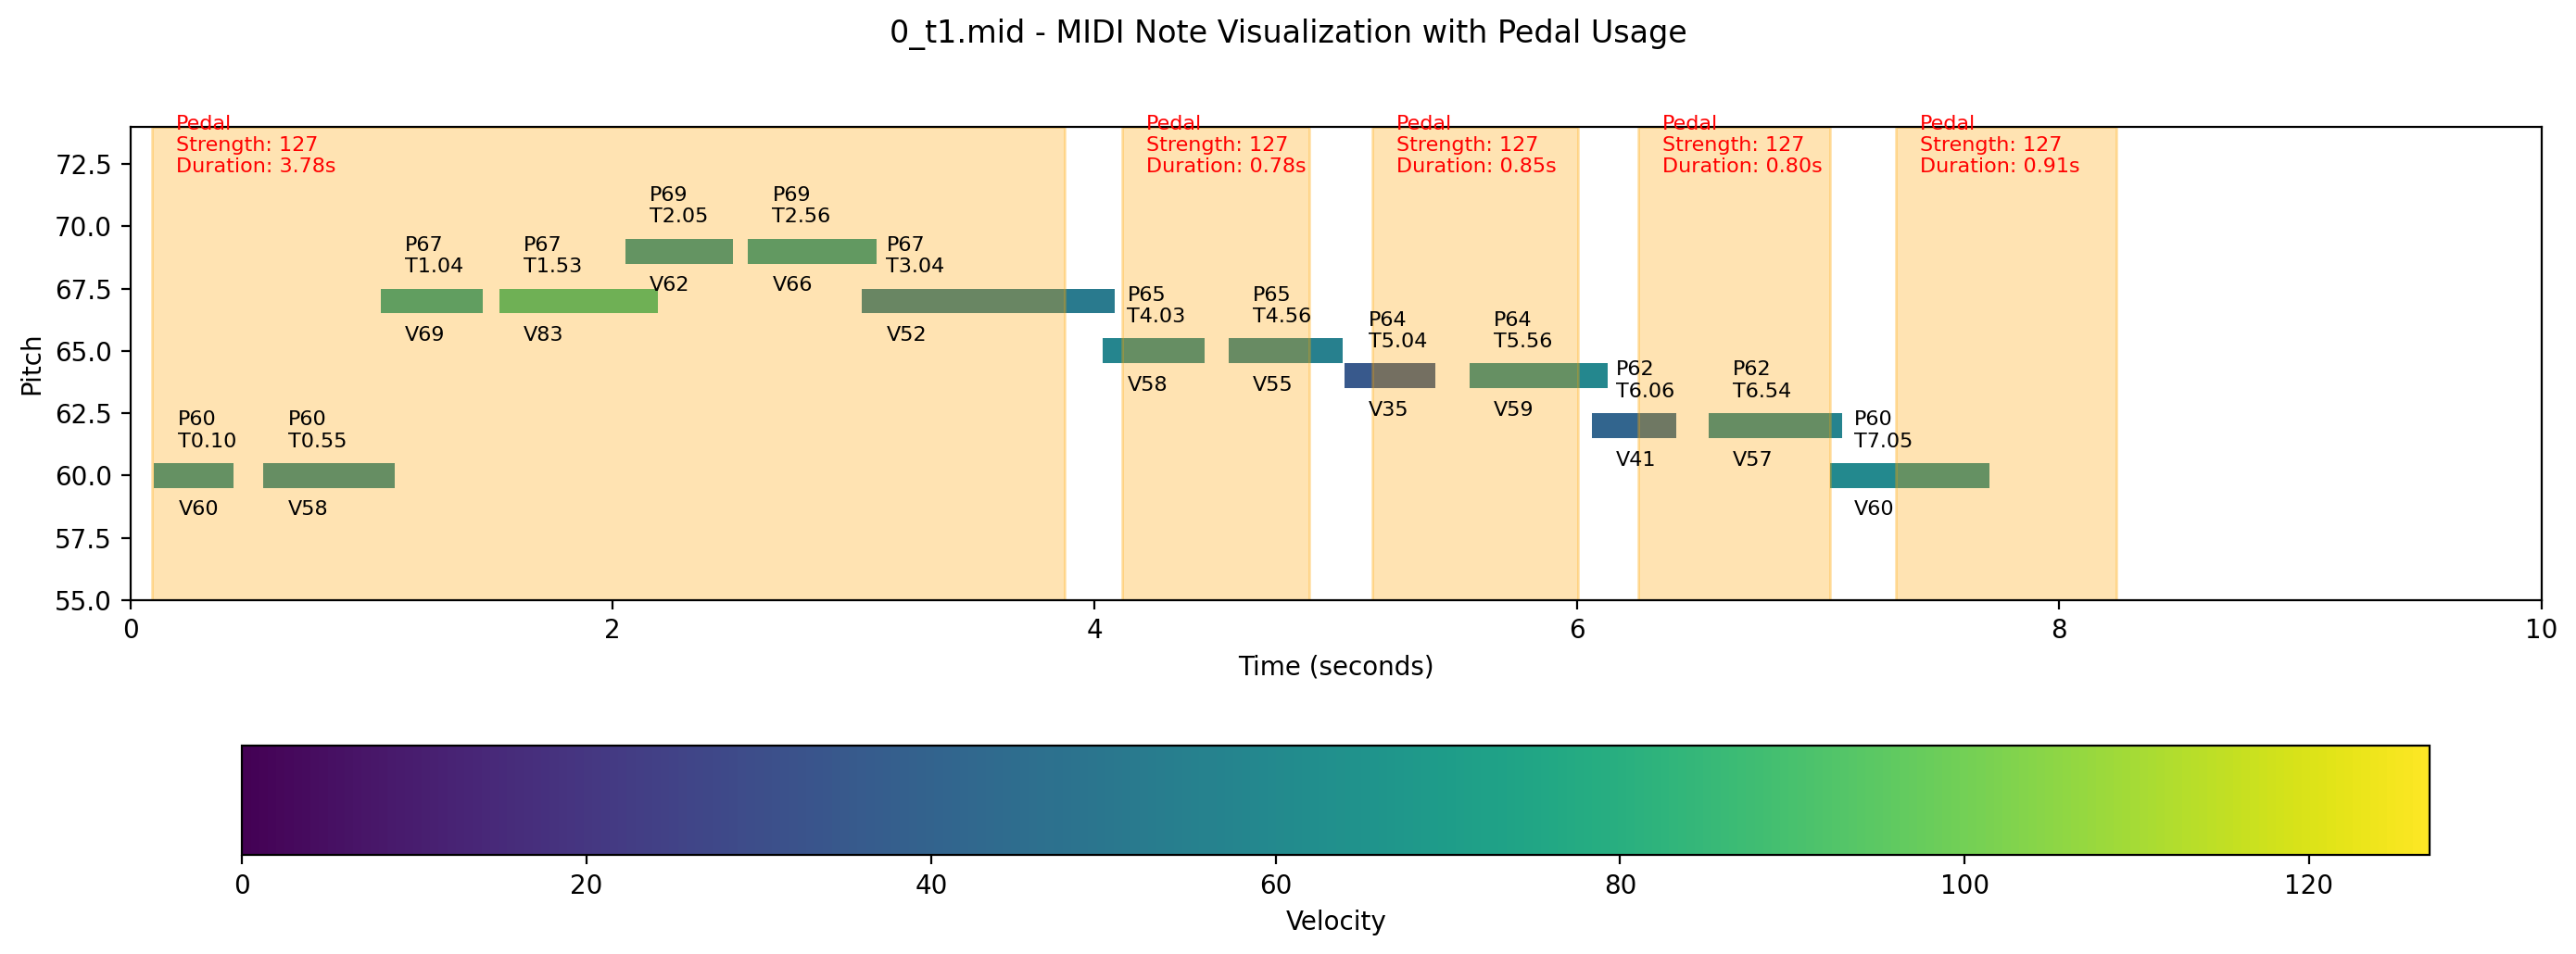

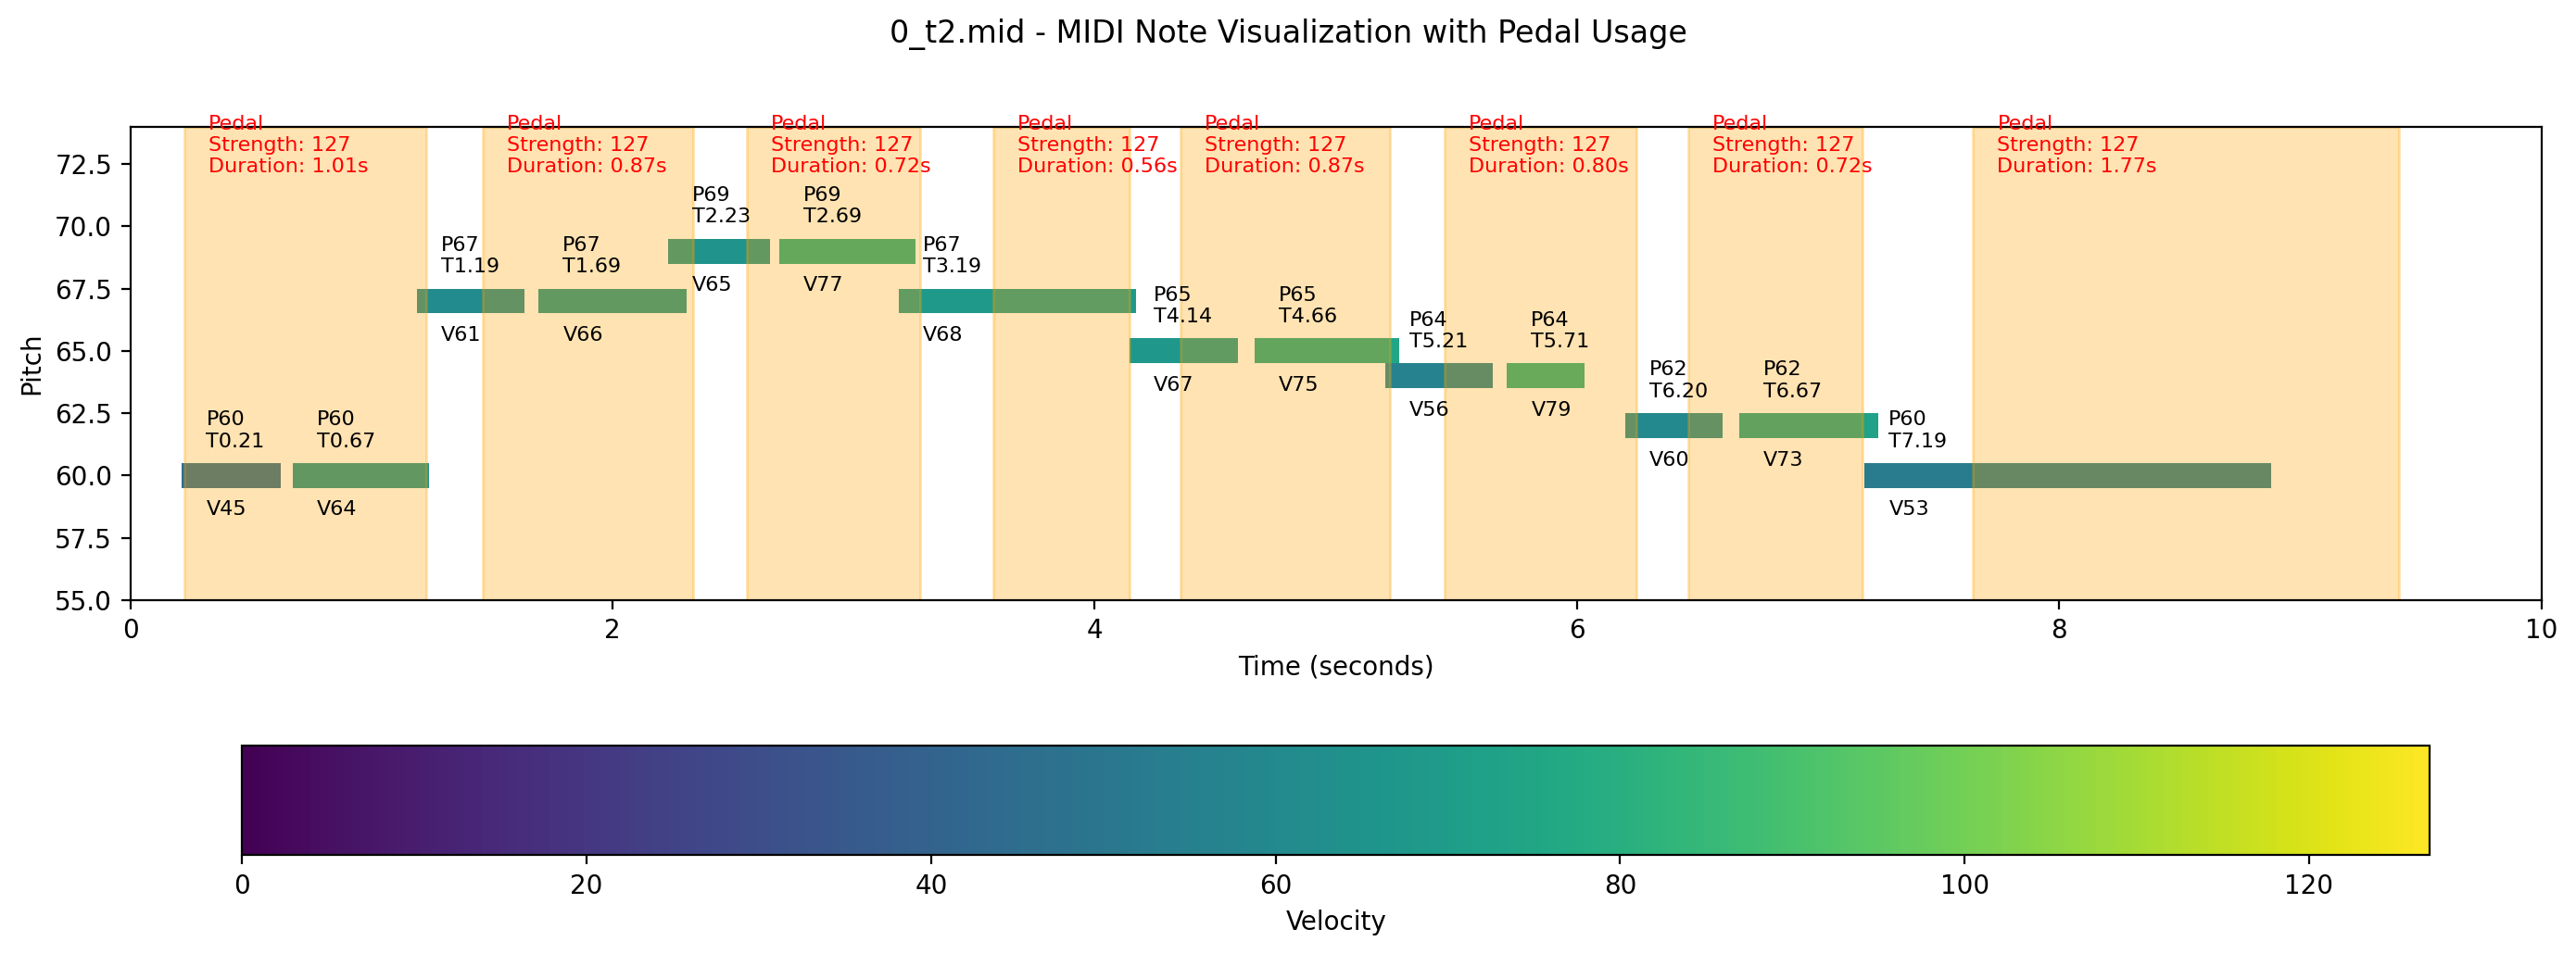

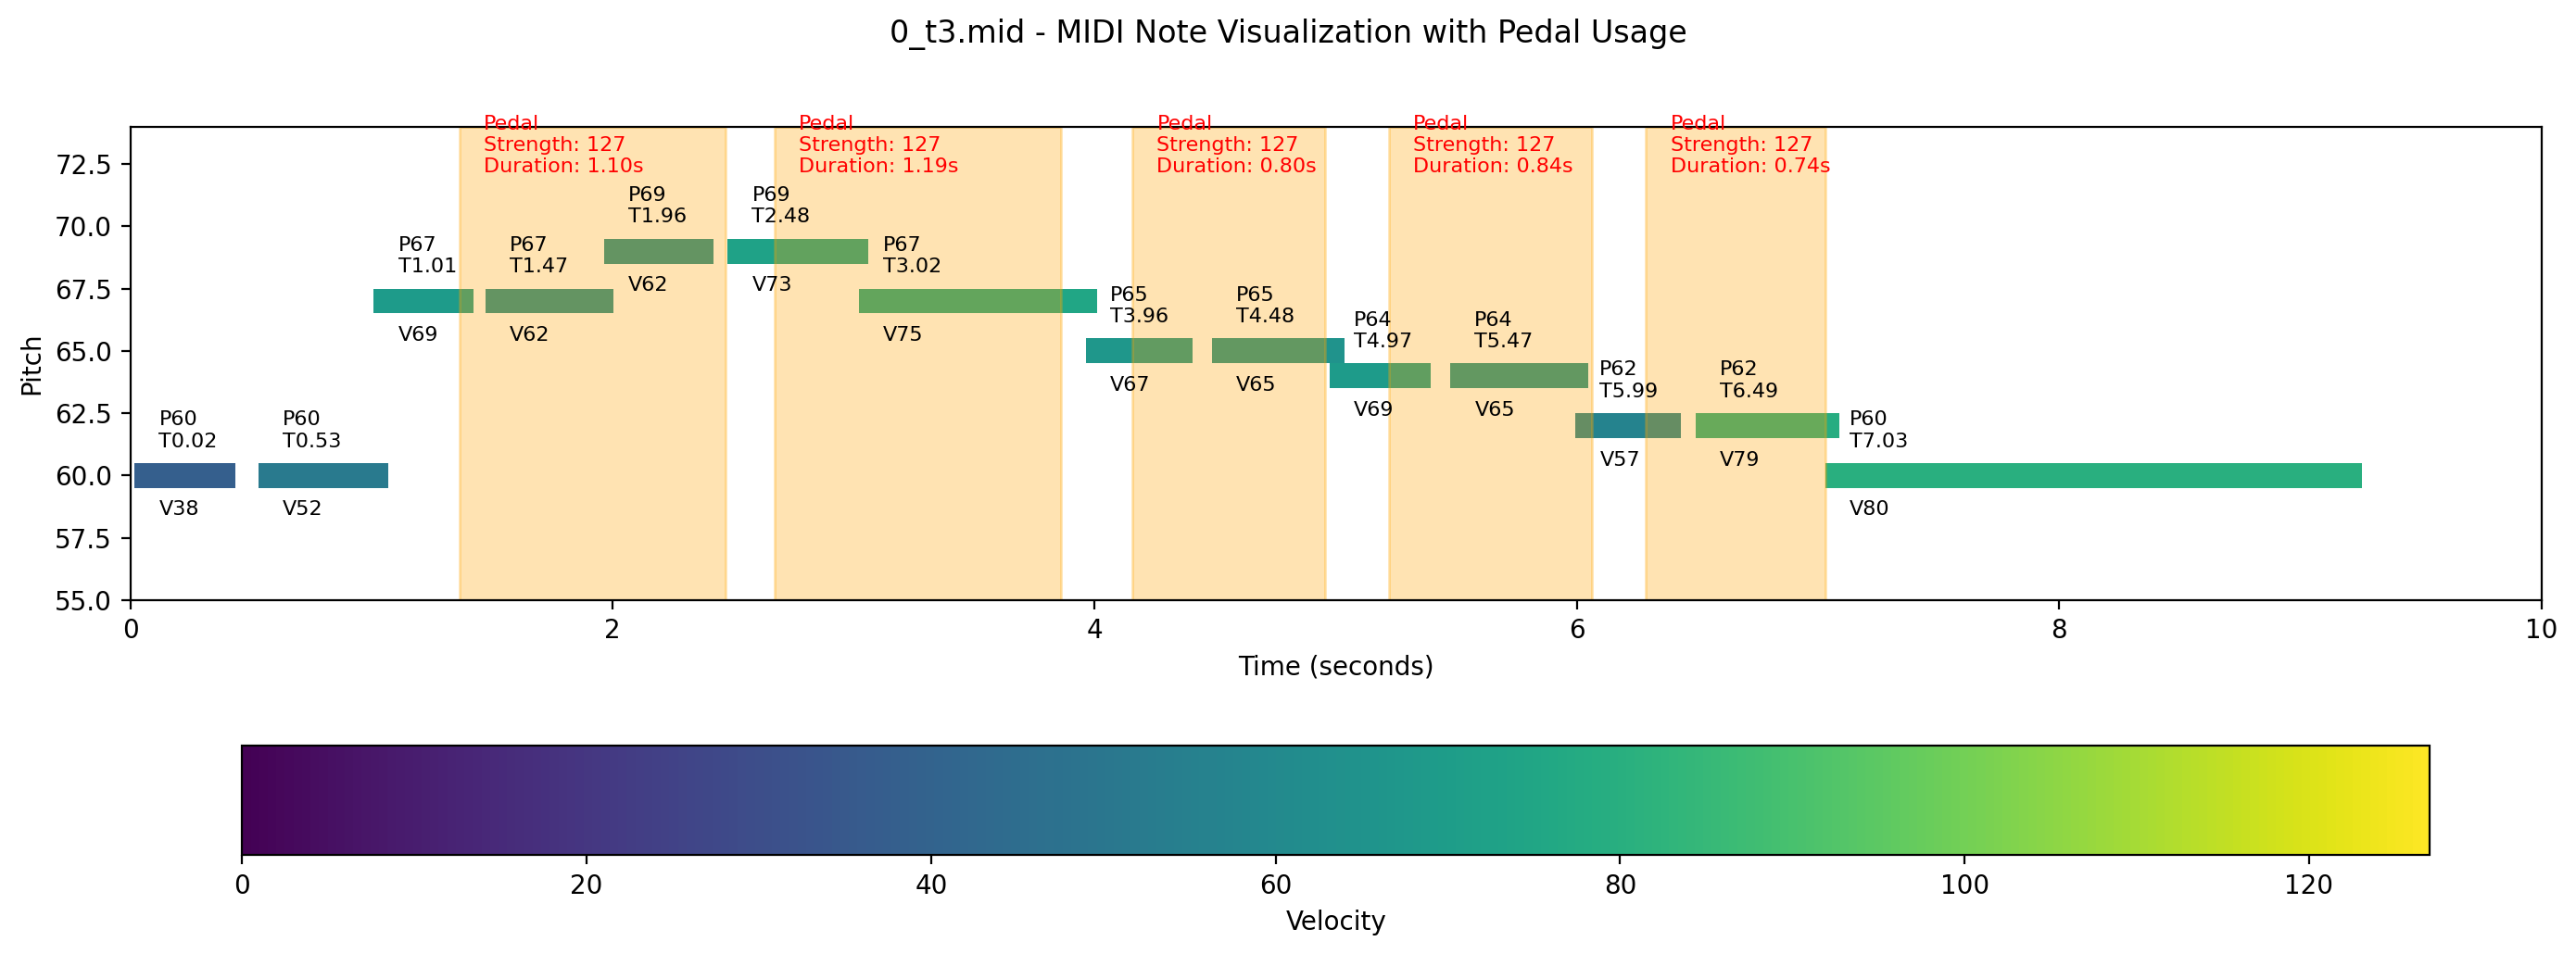

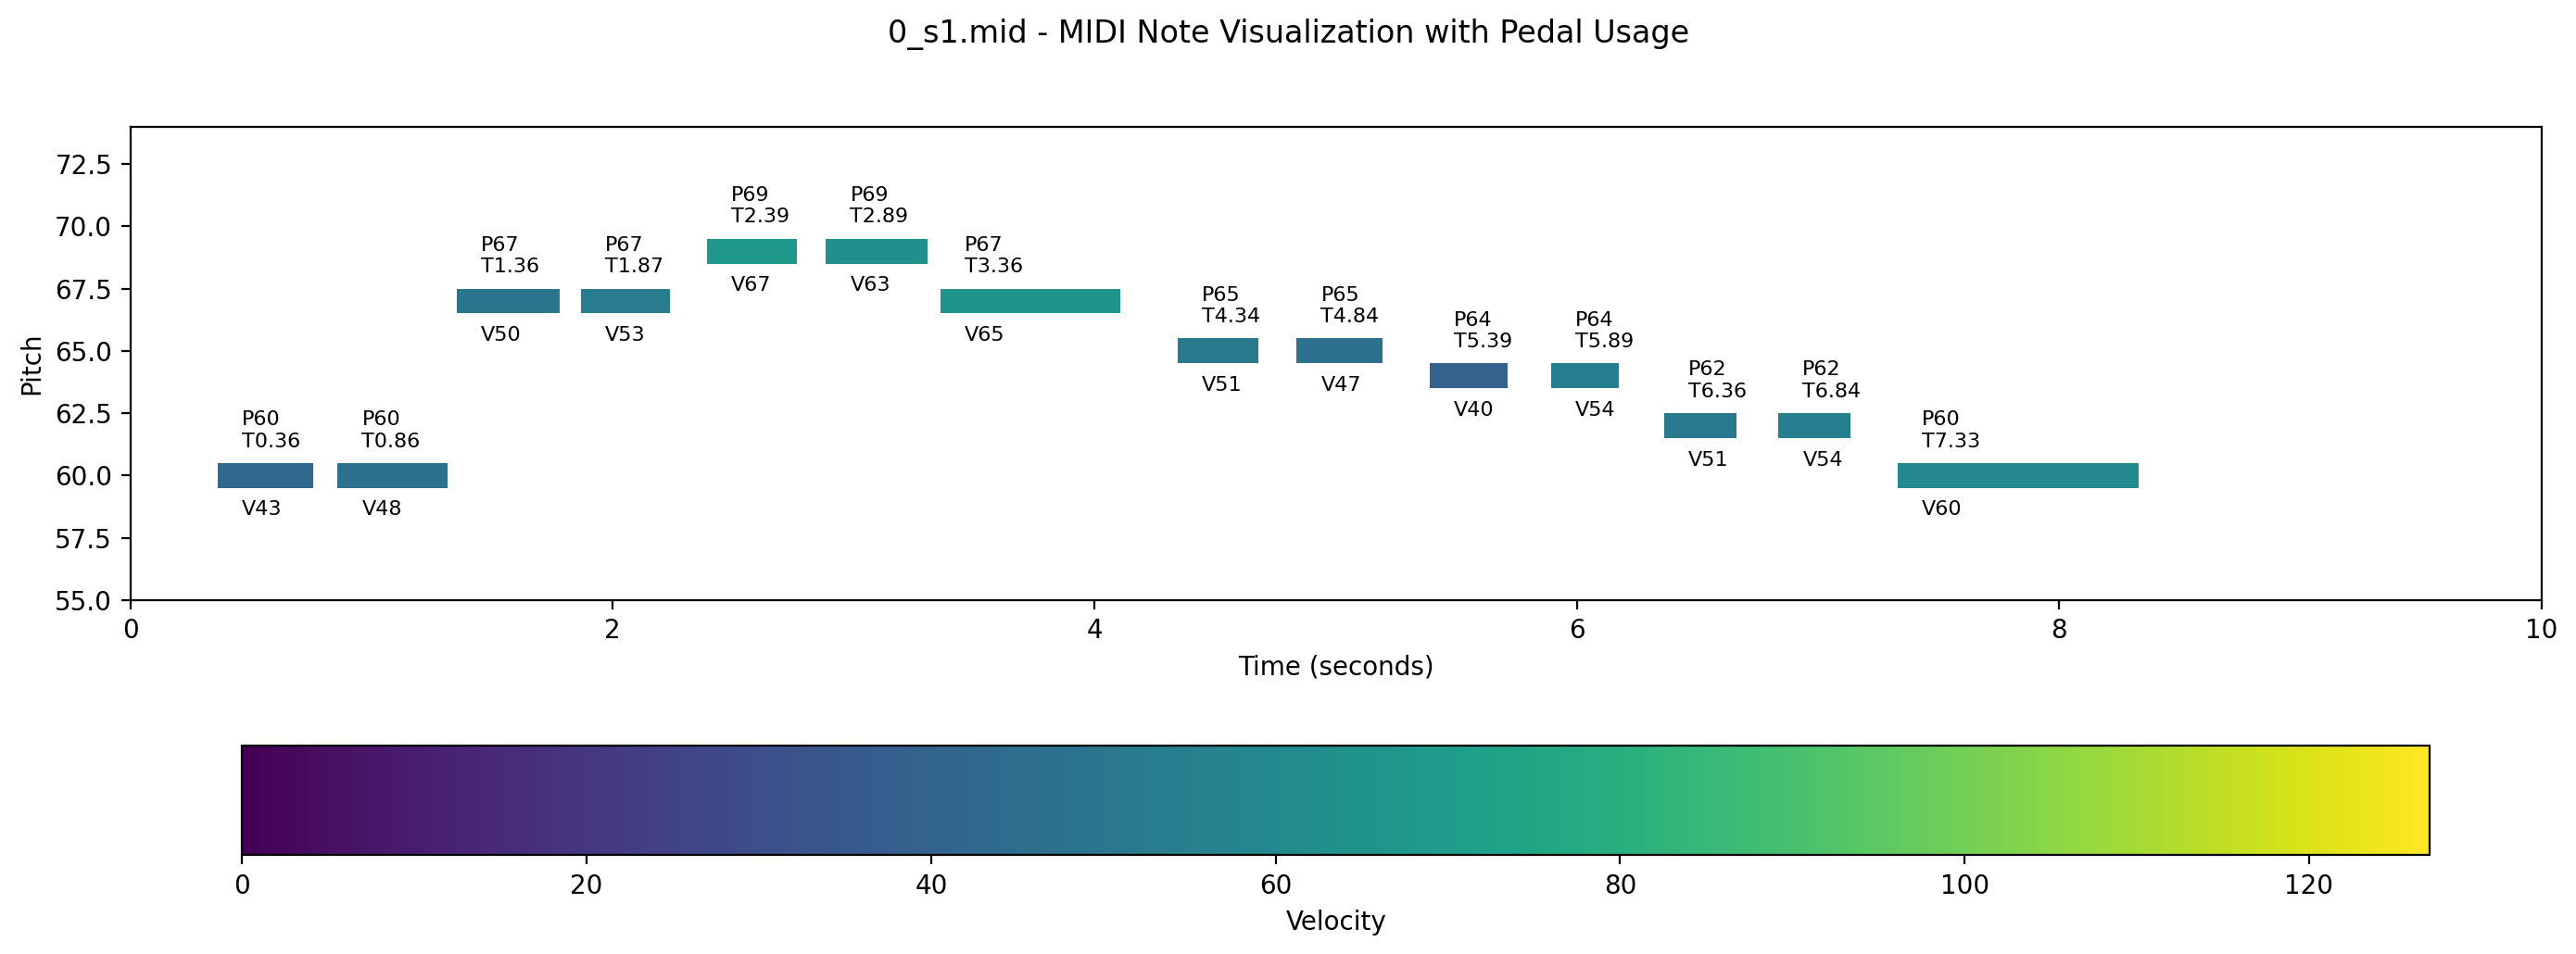

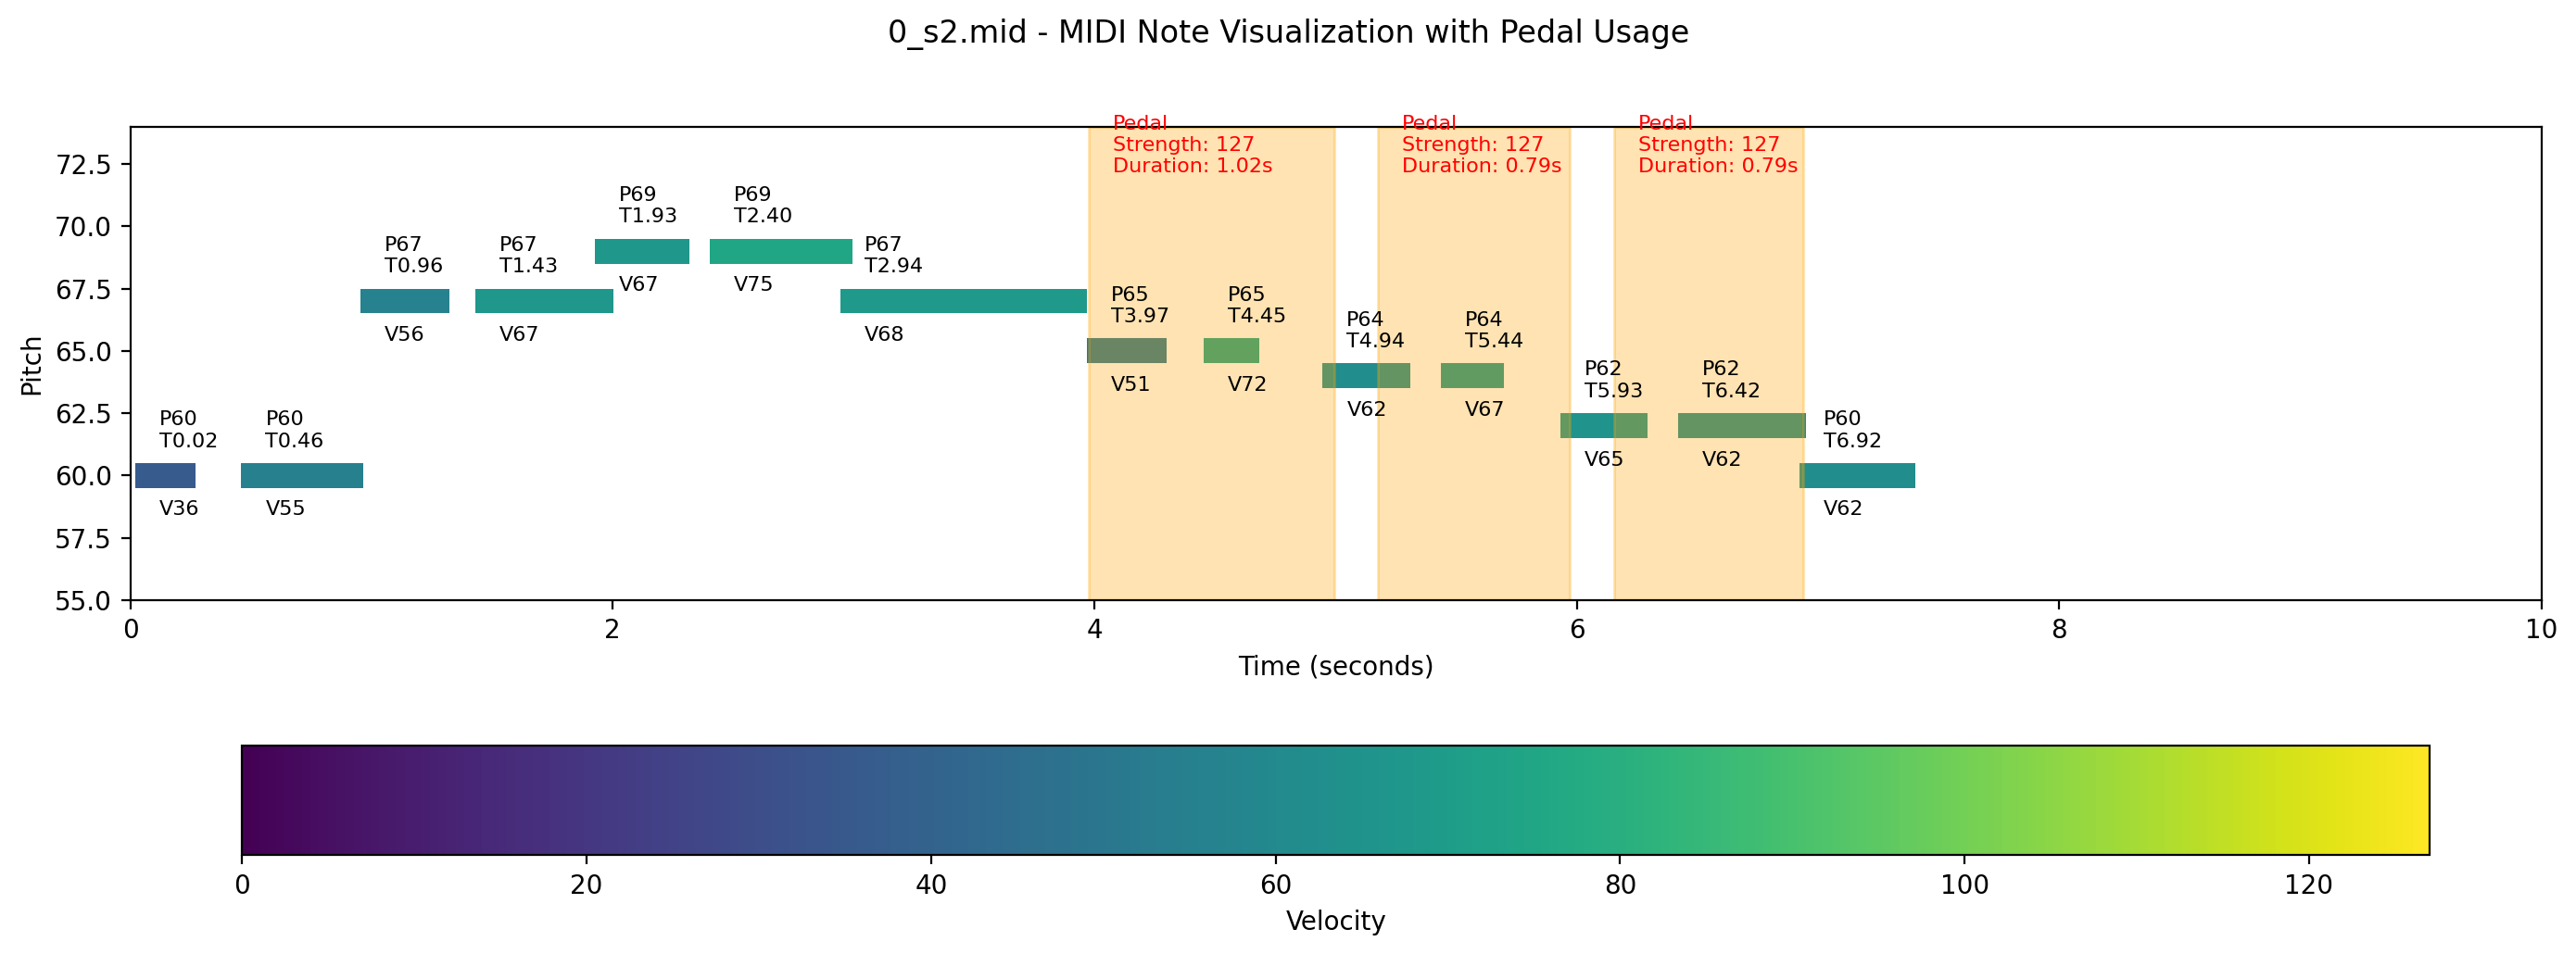

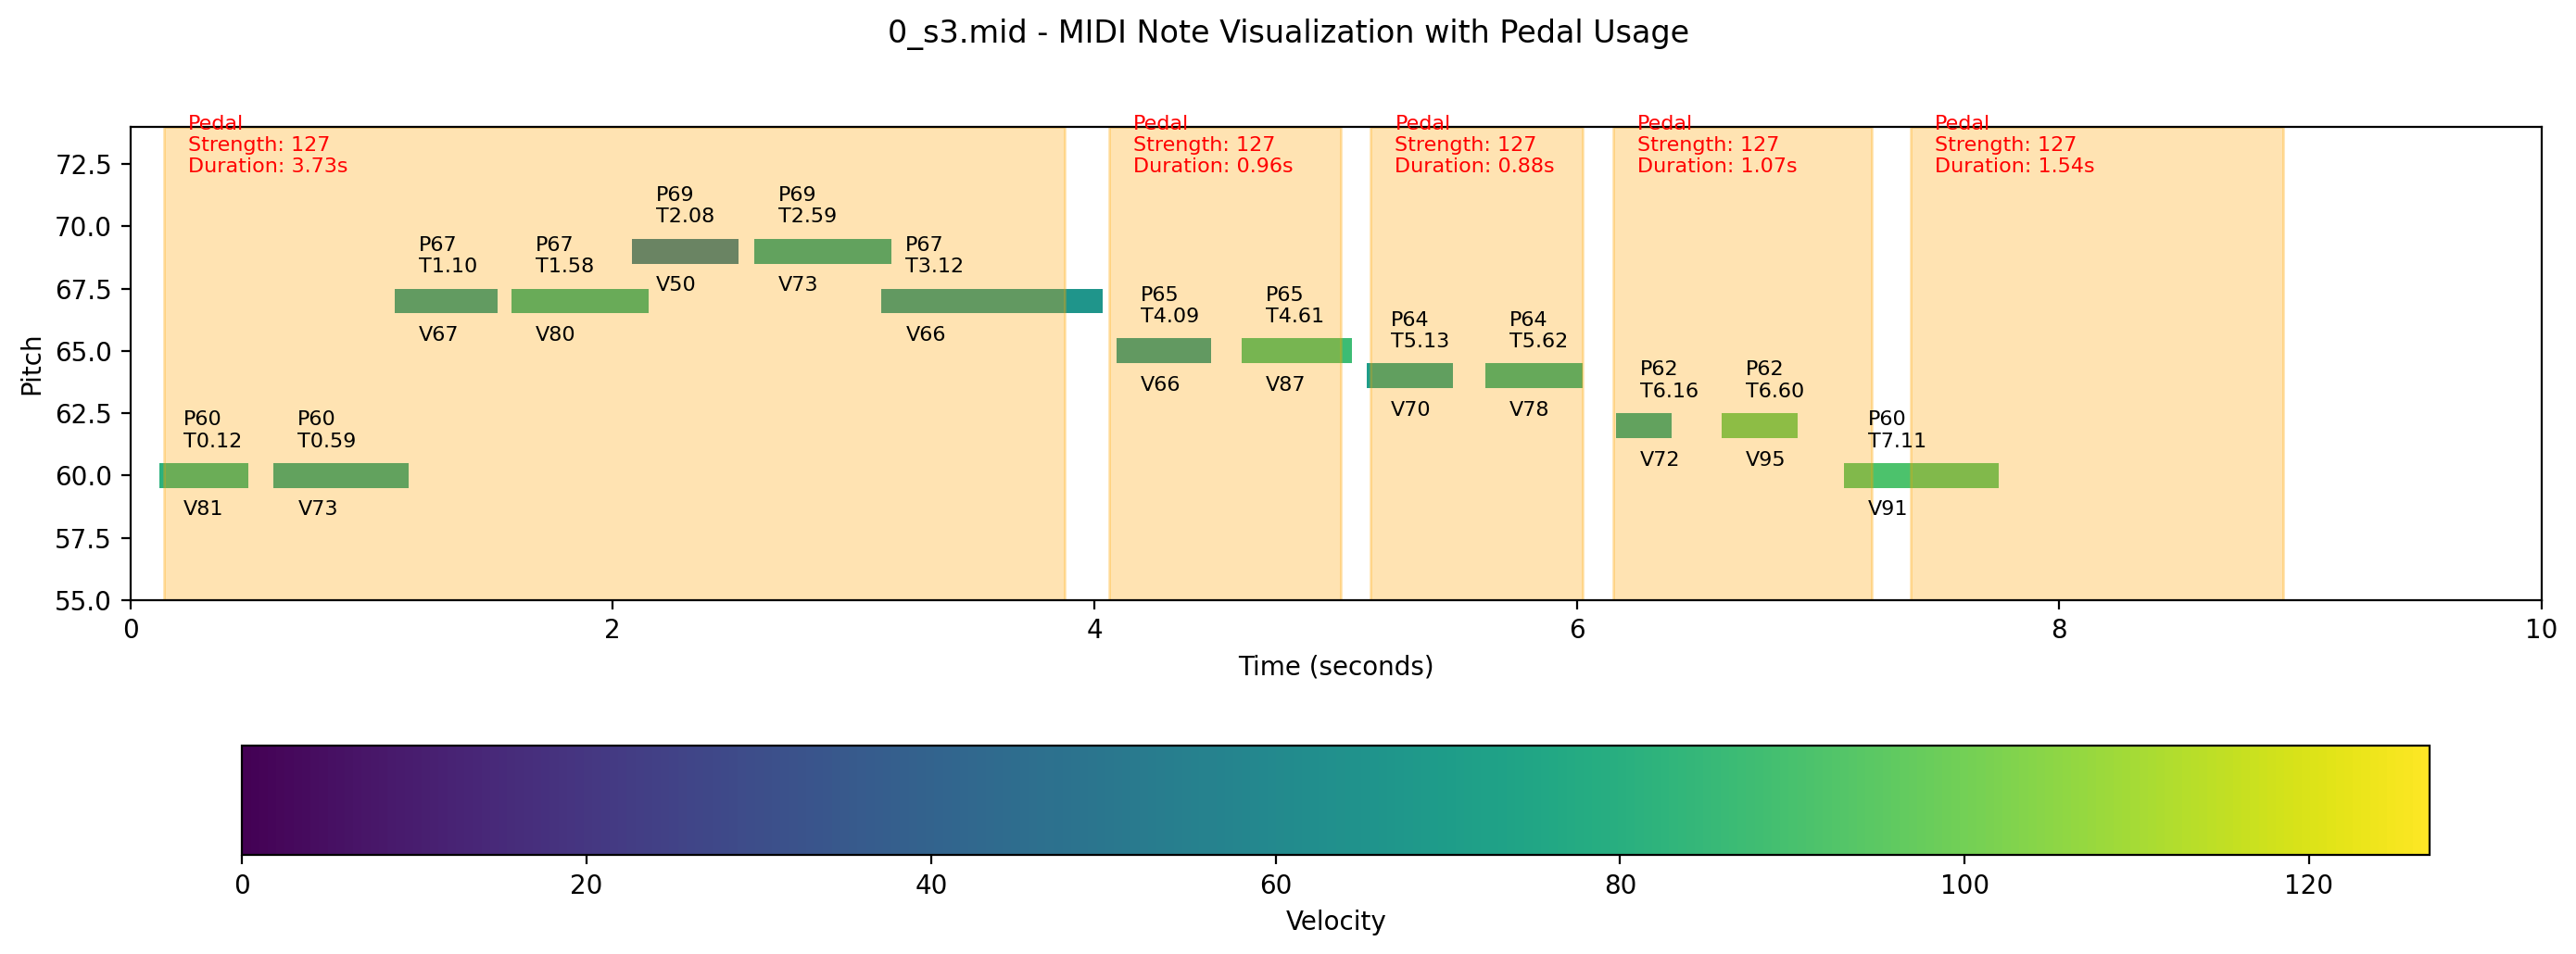

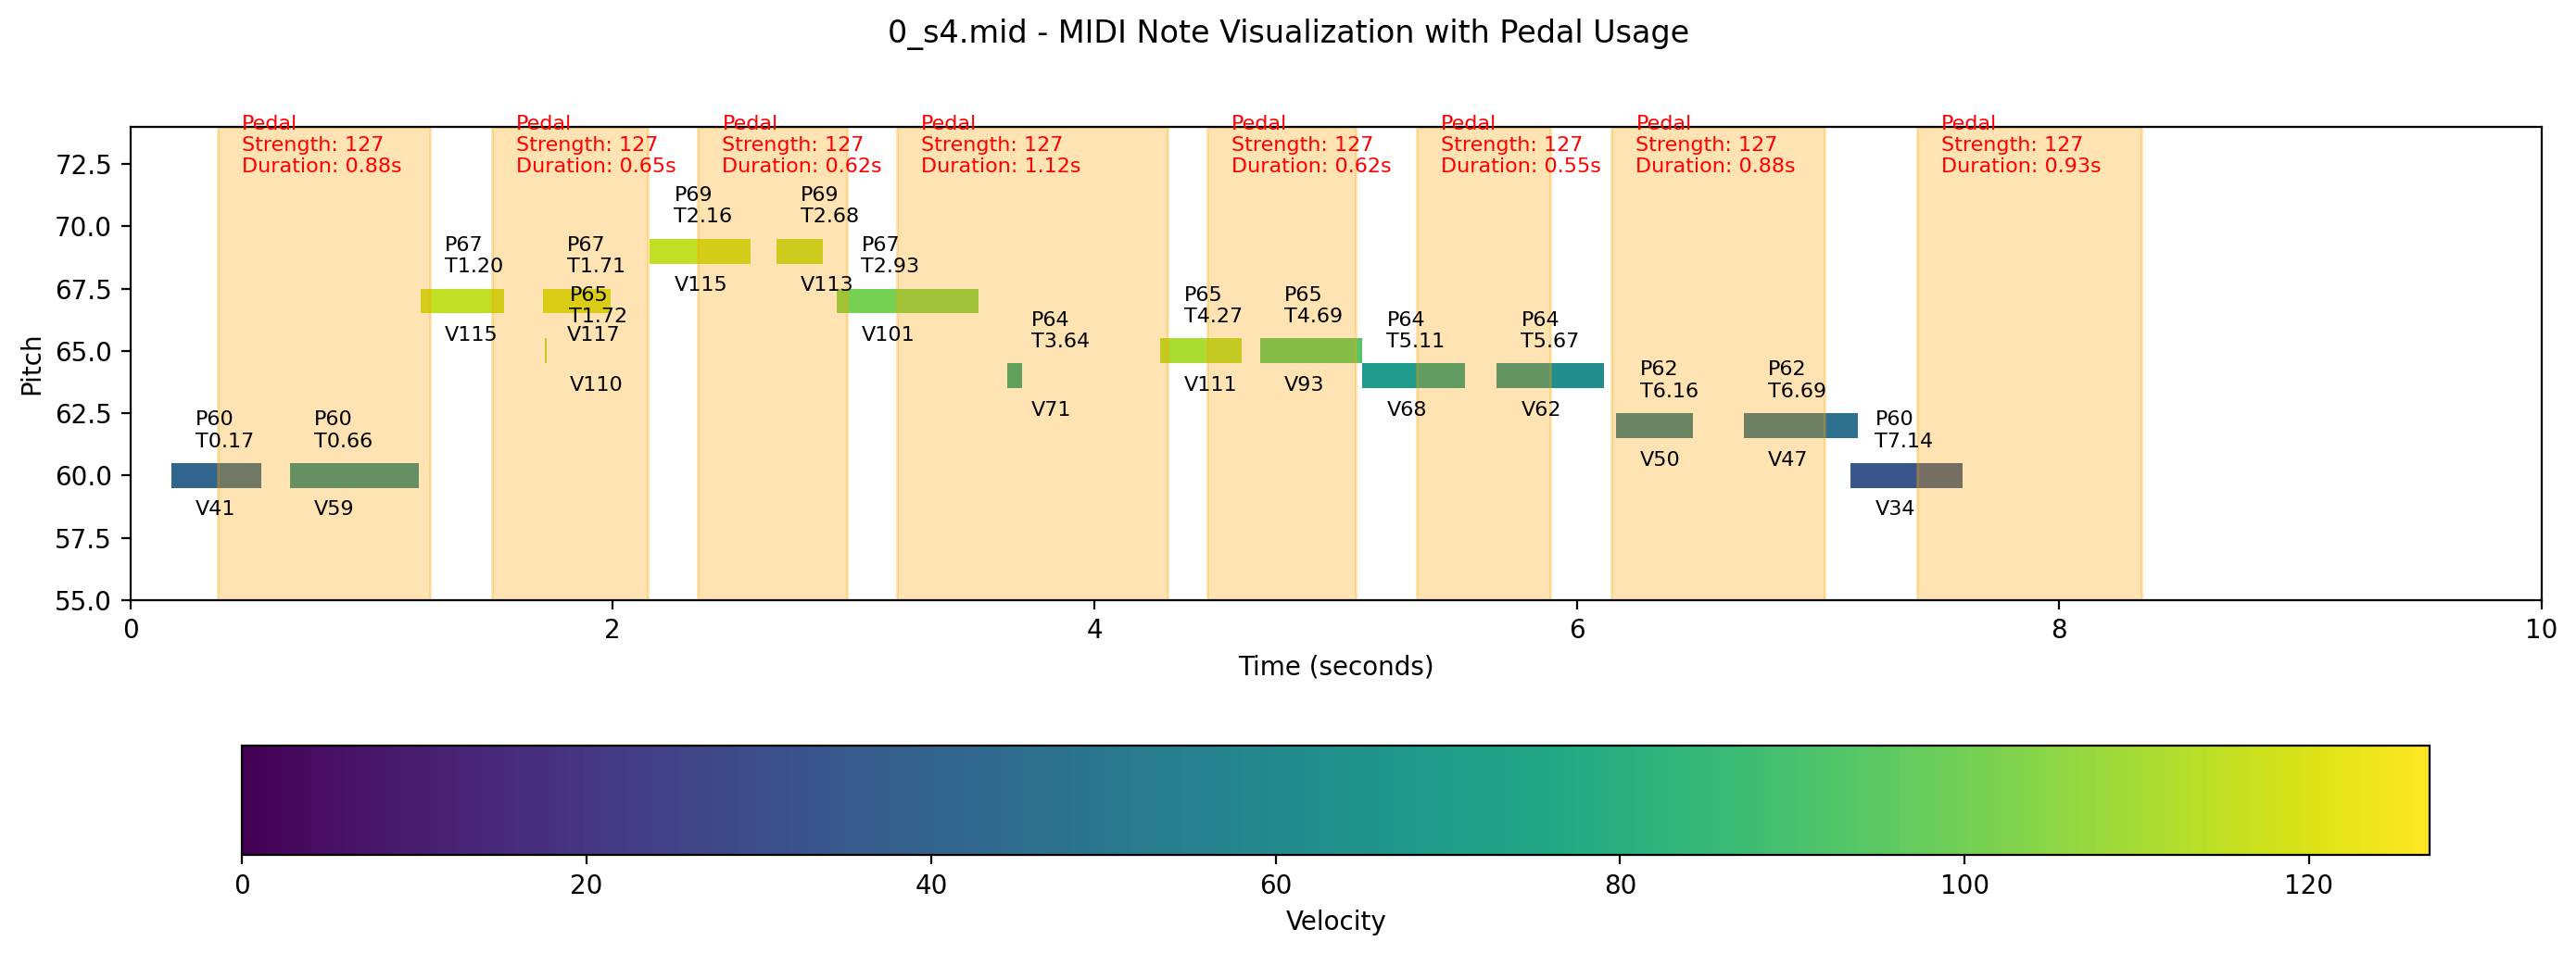

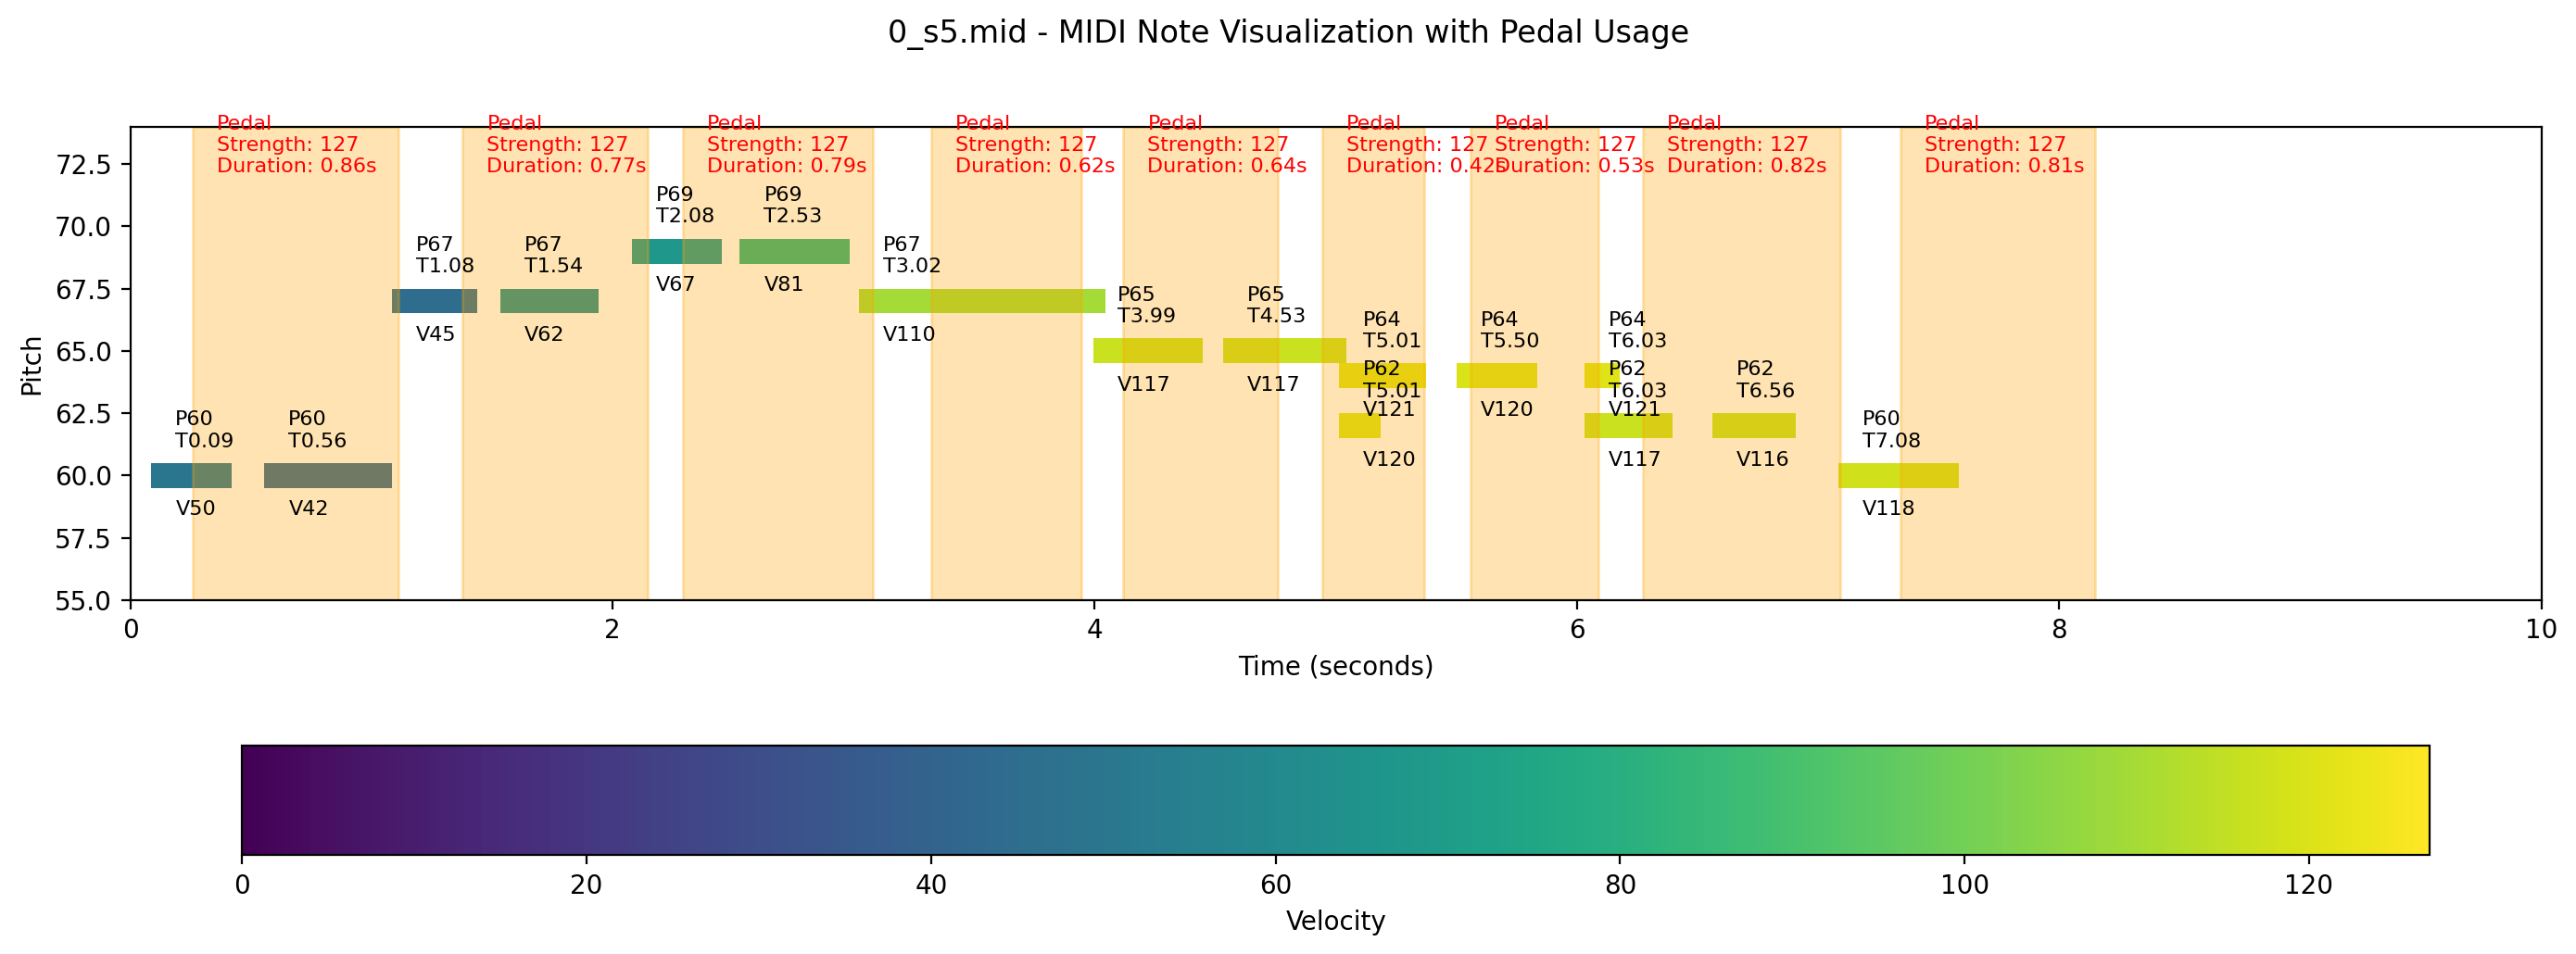

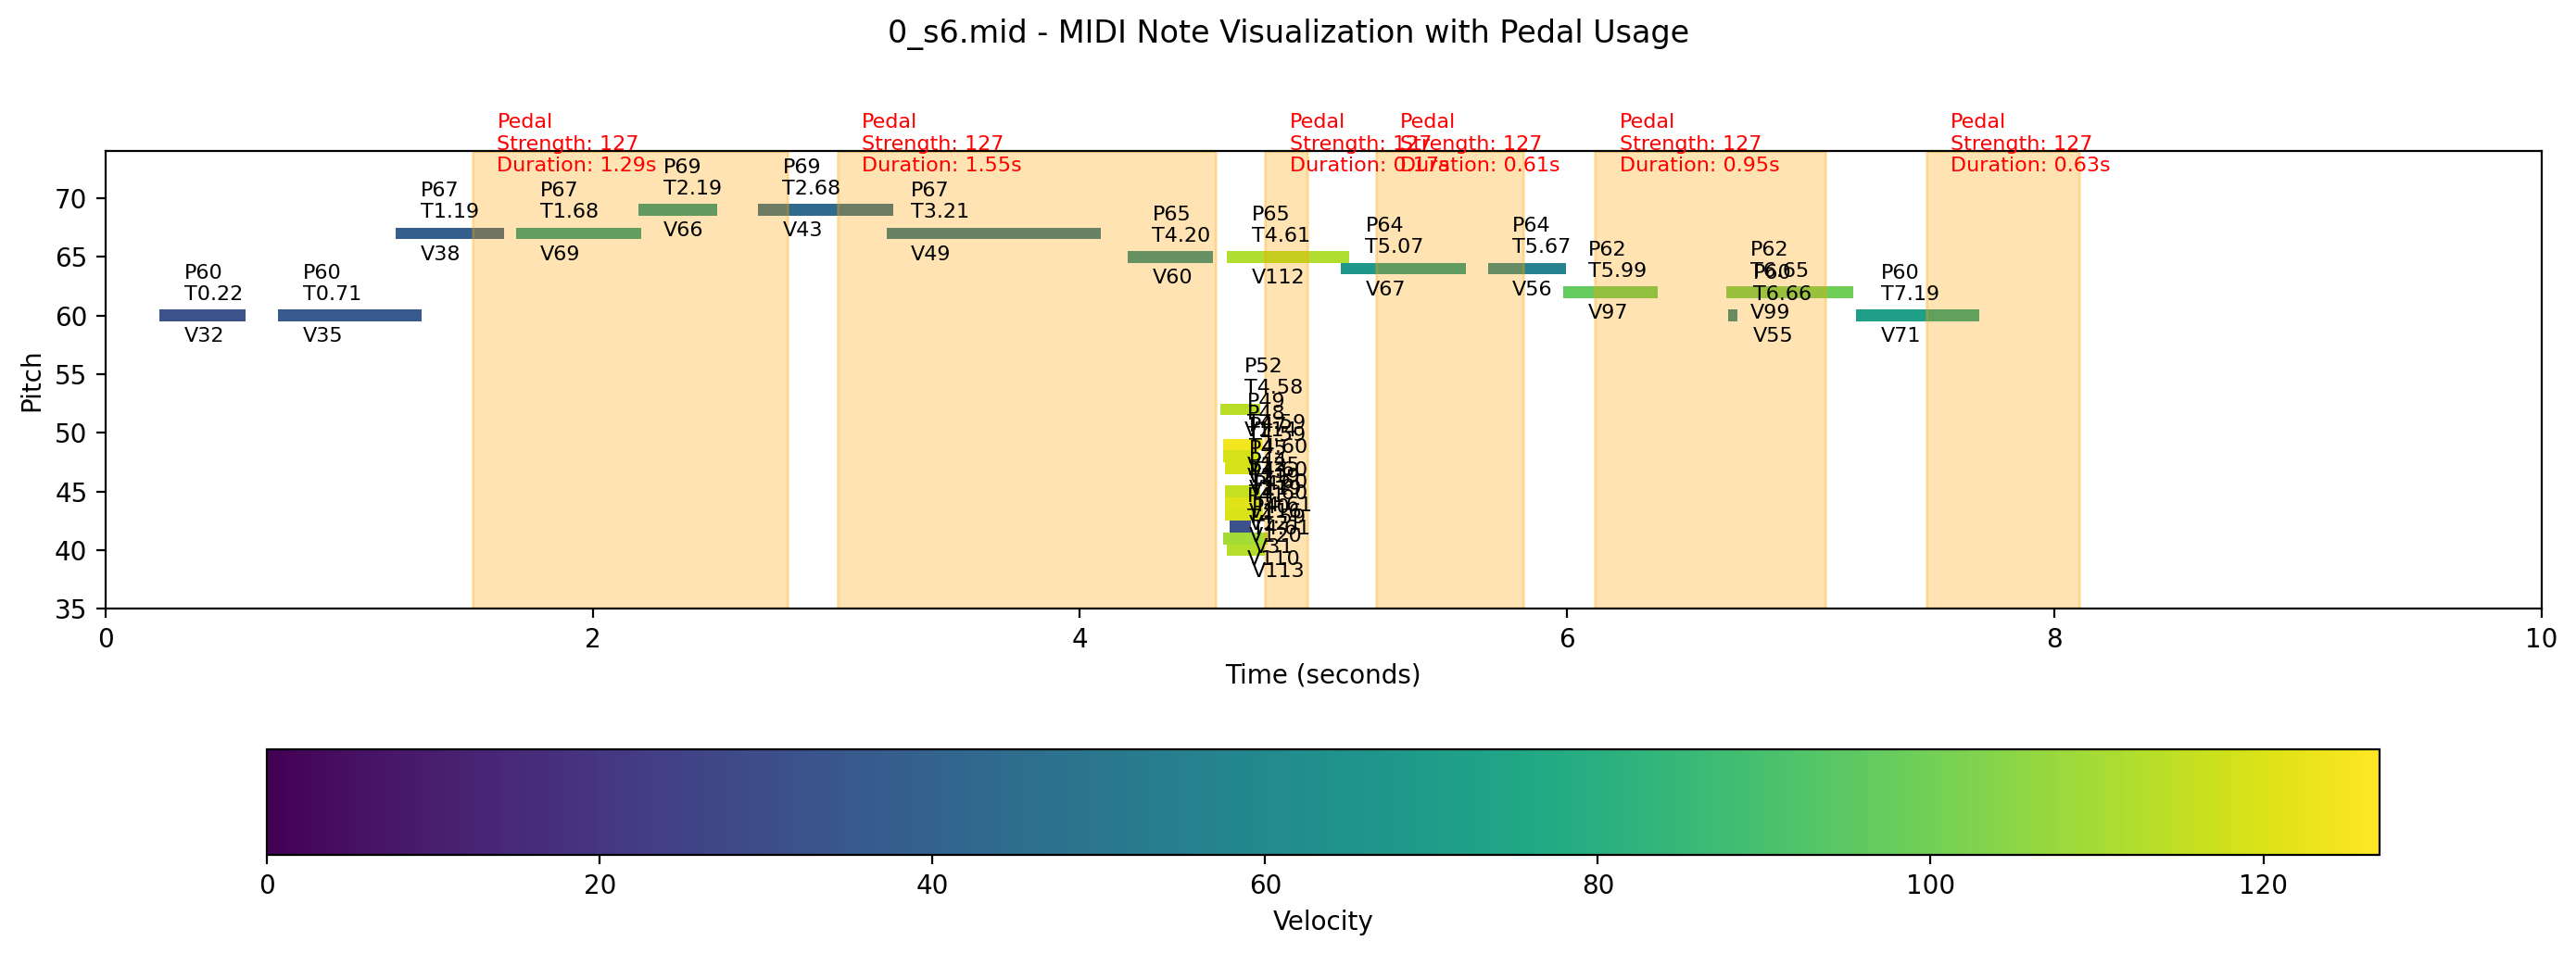

In [185]:
midi_visualize("0_t1.mid")
midi_visualize("0_t2.mid")
midi_visualize("0_t3.mid")
midi_visualize("0_s1.mid")
midi_visualize("0_s2.mid")
midi_visualize("0_s3.mid")
midi_visualize("0_s4.mid")
midi_visualize("0_s5.mid")
midi_visualize("0_s6.mid")


In [165]:
import pretty_midi

def list_all_midi_info(midi_path):
    # 讀取 MIDI 檔案
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    print(f"MIDI 檔案: {midi_path}")
    print(f"總時長: {midi_data.get_end_time()} 秒\n")
    
    # 列出所有速度變化
    print("速度變化 (Tempo Changes):")
    if midi_data.get_tempo_changes():
        tempos, times = midi_data.get_tempo_changes()
        for tempo, time in zip(tempos, times):
            print(f"時間: {time:.2f}s, 速度: {tempo} BPM")
    else:
        print("無速度變化")
    
    # 列出所有拍號變化
    print("\n拍號變化 (Time Signatures):")
    if midi_data.time_signature_changes:
        for ts in midi_data.time_signature_changes:
            print(f"時間: {ts.time:.2f}s, 拍號: {ts.numerator}/{ts.denominator}")
    else:
        print("無拍號變化")
    
    # 列出所有樂器軌道
    for i, instrument in enumerate(midi_data.instruments):
        print(f"\n樂器 {i + 1}:")
        print(f"名稱: {instrument.name if instrument.name else '無名稱'}")
        print(f"是否為鼓組: {'是' if instrument.is_drum else '否'}")
        
        # 列出程式變更 (樂器音色)
        print("程式變更 (Program Change):")
        if instrument.program != None:
            print(f"樂器音色: {instrument.program}（MIDI 樂器號碼）")
        else:
            print("無程式變更")

        # 列出每個音符
        print("\n音符 (Pitch, Start Time, End Time, Velocity):")
        for note in instrument.notes:
            print(f"Pitch: {note.pitch}, 開始時間: {note.start:.2f}s, 結束時間: {note.end:.2f}s, 力度: {note.velocity}")
        
        # 列出控制變更（例如踏板）
        print("\n控制變更（Control Change）:")
        if instrument.control_changes:
            for control in instrument.control_changes:
                print(f"控制號: {control.number}, 時間: {control.time:.2f}s, 值: {control.value}")
        else:
            print("無控制變更")
    
    # 列出音軌的所有拍號 (Time Signatures)
    print("\n音軌中的拍號 (Key Signatures):")
    if midi_data.key_signature_changes:
        for key in midi_data.key_signature_changes:
            print(f"時間: {key.time:.2f}s, 調號: {key.key}")
    else:
        print("無拍號變化")

# 範例使用:
midi_path1 = '0_t1.mid'
midi_path2 = '0_s5.mid'
list_all_midi_info(midi_path1)
list_all_midi_info(midi_path2)



MIDI 檔案: 0_t1.mid
總時長: 8.235416666666666 秒

速度變化 (Tempo Changes):
時間: 120.00s, 速度: 0.0 BPM

拍號變化 (Time Signatures):
無拍號變化

樂器 1:
名稱: 無名稱
是否為鼓組: 否
程式變更 (Program Change):
樂器音色: 0（MIDI 樂器號碼）

音符 (Pitch, Start Time, End Time, Velocity):
Pitch: 60, 開始時間: 0.10s, 結束時間: 0.43s, 力度: 60
Pitch: 60, 開始時間: 0.55s, 結束時間: 1.10s, 力度: 58
Pitch: 67, 開始時間: 1.04s, 結束時間: 1.46s, 力度: 69
Pitch: 67, 開始時間: 1.53s, 結束時間: 2.19s, 力度: 83
Pitch: 69, 開始時間: 2.05s, 結束時間: 2.50s, 力度: 62
Pitch: 69, 開始時間: 2.56s, 結束時間: 3.09s, 力度: 66
Pitch: 67, 開始時間: 3.04s, 結束時間: 4.08s, 力度: 52
Pitch: 65, 開始時間: 4.03s, 結束時間: 4.46s, 力度: 58
Pitch: 65, 開始時間: 4.56s, 結束時間: 5.03s, 力度: 55
Pitch: 64, 開始時間: 5.04s, 結束時間: 5.41s, 力度: 35
Pitch: 64, 開始時間: 5.56s, 結束時間: 6.13s, 力度: 59
Pitch: 62, 開始時間: 6.06s, 結束時間: 6.41s, 力度: 41
Pitch: 62, 開始時間: 6.54s, 結束時間: 7.10s, 力度: 57
Pitch: 60, 開始時間: 7.05s, 結束時間: 7.71s, 力度: 60

控制變更（Control Change）:
控制號: 64, 時間: 0.09s, 值: 127
控制號: 64, 時間: 3.88s, 值: 0
控制號: 64, 時間: 4.11s, 值: 127
控制號: 64, 時間: 4.89s, 值: 0
控制號: 64, 時間: 5.15s, 值: 1

In [292]:
import pretty_midi
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines





def trim_silence(midi_data):
    """移除 MIDI 開頭的靜默部分，返回修剪後的 PrettyMIDI 物件。"""
    min_start_time = min(note.start for instrument in midi_data.instruments for note in instrument.notes)
    
    # 調整所有音符的時間，移除最早開始的靜默時間
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note.start -= min_start_time
            note.end -= min_start_time
    
    return midi_data

def compare_midi_pitch(reference_path, student_path, tolerance=0.1):
    """
    比較範本 MIDI 與學生 MIDI，檢查每個音符是否正確彈奏，並視覺化比較結果。
    
    :param reference_path: 範本 MIDI 檔案的路徑
    :param student_path: 學生 MIDI 檔案的路徑
    :param tolerance: 容差值，用於比較音符的開始時間
    :return: 正確音符, 多餘音符, 缺失音符
    """
    ref_midi = trim_silence(pretty_midi.PrettyMIDI(reference_path))
    student_midi = trim_silence(pretty_midi.PrettyMIDI(student_path))
    
    # 提取範本和學生的所有音符
    ref_notes = [(note.pitch, note.start, '範本') for instrument in ref_midi.instruments for note in instrument.notes]
    student_notes = [(note.pitch, note.start, '學生') for instrument in student_midi.instruments for note in instrument.notes]
    
    all_notes = []
    correct_notes = []
    extra_notes = []
    missing_notes = []
    used_student_indices = set()  # 紀錄已使用的學生音符索引，避免重複使用

    for ref_pitch, ref_start, _ in ref_notes:
        closest_student_index = None
        closest_time_diff = float('inf')
        
        # 找到最接近的學生音符
        for i, (student_pitch, student_start, _) in enumerate(student_notes):
            if i in used_student_indices:
                continue  # 已使用過的學生音符跳過
            
            time_diff = abs(ref_start - student_start)
            if student_pitch == ref_pitch and time_diff <= tolerance and time_diff < closest_time_diff:
                closest_student_index = i
                closest_time_diff = time_diff
        
        # 根據找到的學生音符決定是否匹配正確
        if closest_student_index is not None:
            all_notes.append((ref_pitch, ref_start, student_notes[closest_student_index][1], '正確'))
            correct_notes.append((ref_pitch, ref_start, student_notes[closest_student_index][1]))  # 記錄正確音符
            used_student_indices.add(closest_student_index)  # 標記該學生音符已使用
        else:
            all_notes.append((ref_pitch, ref_start, None, '缺失音符'))
            missing_notes.append((ref_pitch, ref_start))  # 缺失音符

    # 找出學生中多餘的音符
    for i, (student_pitch, student_start, _) in enumerate(student_notes):
        if i not in used_student_indices:
            all_notes.append((student_pitch, None, student_start, '多餘音符'))
            extra_notes.append((student_pitch, student_start))  # 多餘音符

    # 根據時間排序
    all_notes.sort(key=lambda x: (x[1] if x[1] is not None else x[2]))

    # 列出結果
    for note in all_notes:
        if note[3] == '正確':
            print(f"正確: Pitch {note[0]}, 範本時間 {note[1]:.2f}s, 學生時間 {note[2]:.2f}s 在容差 {tolerance}s 內")
        elif note[3] == '缺失音符':
            print(f"缺失音符: Pitch {note[0]}, 範本時間 {note[1]:.2f}s")
        else:
            print(f"多餘音符: Pitch {note[0]}, 學生時間 {note[2]:.2f}s")

    # 列出結果摘要
    print("\n比較結果:")
    correct_count = len([note for note in all_notes if note[3] == '正確'])
    missing_count = len([note for note in all_notes if note[3] == '缺失音符'])
    extra_count = len([note for note in all_notes if note[3] == '多餘音符'])

    print(f"正確音符數: {correct_count}")
    print(f"多餘音符數: {extra_count}")
    print(f"缺失音符數: {missing_count}")


    midi_visualize(reference_path)
    midi_visualize(student_path)
    
    # 開始進行視覺化
    total_time = max(max(note.end for note in instrument.notes) for instrument in ref_midi.instruments + student_midi.instruments)
    time_per_row = 10
    num_rows = int(total_time // time_per_row) + 1

    plt.figure(figsize=(14, num_rows * 10))  # 調整高度以顯示兩個圖表
    
    # 第1個圖：範本的音符
    for row in range(num_rows):
        plt.subplot(2 * num_rows, 1, row * 2 + 1)
        
        start_time = row * time_per_row
        end_time = (row + 1) * time_per_row

        # 繪製範本音符 (淡綠色，忽略力度)
        for instrument in ref_midi.instruments:
            for note in instrument.notes:
                if start_time <= note.start < end_time:
                    plt.barh(note.pitch, note.end - note.start, left=note.start, height=1, color='lightgreen')
                    plt.axvline(x=note.start, color='black', linestyle='--', linewidth=0.25, alpha=0.7, ymin=-10, ymax=2)  # 繪製垂直線
                    plt.text(note.start + 0.1, note.pitch + 1, f'P{note.pitch}\nT{note.start:.2f}', va='bottom', fontsize=8, ha='left')

        # 標註 x 軸與 y 軸
        if row == num_rows - 1:
            plt.xlabel('Time (seconds)')
        plt.ylabel('Pitch')
        plt.title(f'{reference_path} - reference MIDI pitch visualize', pad = 25)
        plt.xlim(start_time, end_time)

            
        # 第2個圖：學生的音符
        
        for row in range(num_rows):
            plt.subplot(2 * num_rows, 1, row * 2 + 2)
            
            start_time = row * time_per_row
            end_time = (row + 1) * time_per_row
            
            # 繪製學生音符
            for instrument in student_midi.instruments:
                for note in instrument.notes:
                    if start_time <= note.start < end_time:
                        # 根據音符是否正確、錯誤設置顏色，並允許容差
                        is_correct = any(abs(note.pitch - cn[0]) < 1e-3 and abs(note.start - cn[2]) <= tolerance for cn in correct_notes)
                        is_extra = any(abs(note.pitch - en[0]) < 1e-3 and abs(note.start - en[1]) <= tolerance for en in extra_notes)
                        
                        if is_correct:
                            color = 'lightgreen'  # 正確音符
                            label = 'Correct note'
                        elif is_extra:
                            color = 'red'  # 多餘音符
                            label = 'Extra note'
                        else:
                            color = 'orange'  # 缺失音符
                            label = 'Missing note'
        
                        plt.barh(note.pitch, note.end - note.start, left=note.start, height=1, color=color, alpha=1 if is_correct else 0.7)
                        plt.text(note.start + 0.1, note.pitch + 1, f'P{note.pitch}\nT{note.start:.2f}', va='bottom', fontsize=8, ha='left')
        # 添加圖例解釋顏色意義
        tolerance_label = mlines.Line2D([], [], linestyle='', label=f'tolerance: {tolerance}(sec)')
        correct_patch = mpatches.Patch(color='lightgreen', label='Correct note')
        extra_patch = mpatches.Patch(color='red', label='Extra note')
        missing_patch = mpatches.Patch(color='orange', label='Missing note')
        ref_note_start_patch = mlines.Line2D([], [], color='black', linestyle='--', label='Reference note start')

        for instrument in ref_midi.instruments:
            for note in instrument.notes:
                plt.axvline(x=note.start, color='black', linestyle='--', linewidth=0.25, alpha=0.7, ymin=-10, ymax=2)  # 繪製垂直線
        
        plt.title(f'{student_path} - student MIDI pitch correctness', pad = 25)
        plt.legend(handles=[correct_patch, extra_patch, missing_patch, ref_note_start_patch, tolerance_label], loc='upper right')
        plt.subplots_adjust(hspace=0.5)  # 將 hspace 設置為一個較大的值來增加間距
        plt.xlim(start_time, end_time)
        plt.show()
        

    print('(Pitch, ref_time, stu_time(s))')
    print('correct_notes:')
    display(correct_notes)
    print('\nextra_notes:')
    display(extra_notes)
    print('\nmissing_note:')
    display(missing_notes)

正確: Pitch 60, 範本時間 0.00s, 學生時間 0.00s 在容差 0.1s 內
正確: Pitch 60, 範本時間 0.45s, 學生時間 0.49s 在容差 0.1s 內
正確: Pitch 67, 範本時間 0.94s, 學生時間 0.97s 在容差 0.1s 內
正確: Pitch 67, 範本時間 1.43s, 學生時間 1.46s 在容差 0.1s 內
正確: Pitch 69, 範本時間 1.95s, 學生時間 1.97s 在容差 0.1s 內
正確: Pitch 69, 範本時間 2.46s, 學生時間 2.46s 在容差 0.1s 內
正確: Pitch 67, 範本時間 2.94s, 學生時間 2.99s 在容差 0.1s 內
正確: Pitch 65, 範本時間 3.94s, 學生時間 3.98s 在容差 0.1s 內
多餘音符: Pitch 52, 學生時間 4.35s
多餘音符: Pitch 48, 學生時間 4.36s
多餘音符: Pitch 49, 學生時間 4.36s
多餘音符: Pitch 41, 學生時間 4.36s
多餘音符: Pitch 47, 學生時間 4.37s
多餘音符: Pitch 45, 學生時間 4.37s
多餘音符: Pitch 43, 學生時間 4.37s
多餘音符: Pitch 44, 學生時間 4.37s
多餘音符: Pitch 40, 學生時間 4.38s
多餘音符: Pitch 42, 學生時間 4.39s
正確: Pitch 65, 範本時間 4.46s, 學生時間 4.38s 在容差 0.1s 內
正確: Pitch 64, 範本時間 4.94s, 學生時間 4.85s 在容差 0.1s 內
正確: Pitch 64, 範本時間 5.46s, 學生時間 5.45s 在容差 0.1s 內
多餘音符: Pitch 62, 學生時間 5.76s
缺失音符: Pitch 62, 範本時間 5.96s
多餘音符: Pitch 60, 學生時間 6.44s
正確: Pitch 62, 範本時間 6.45s, 學生時間 6.43s 在容差 0.1s 內
正確: Pitch 60, 範本時間 6.95s, 學生時間 6.97s 在容差 0.1s 內

比較結果:
正確音符數: 13
多餘音符數: 1

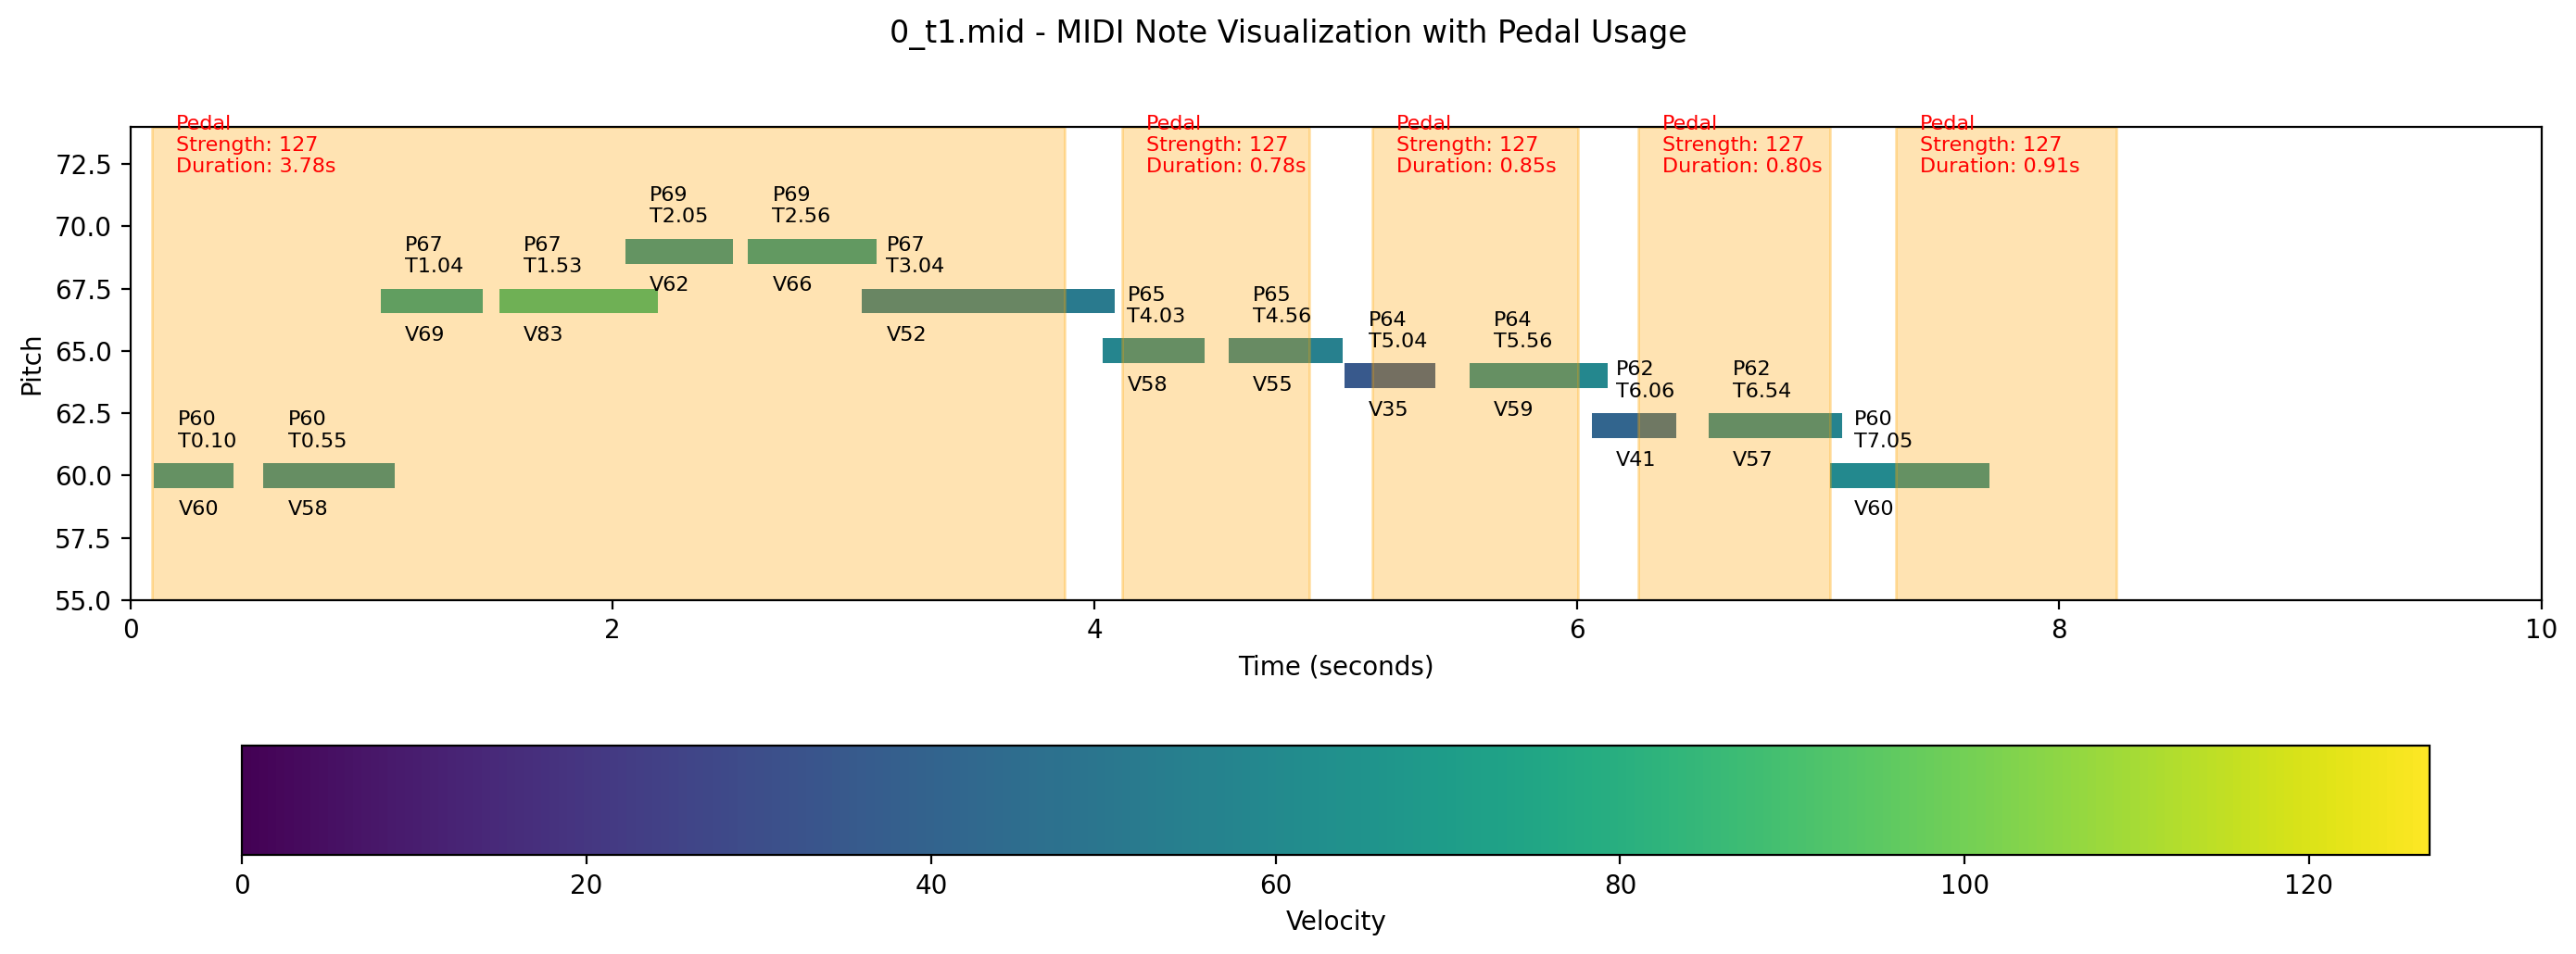

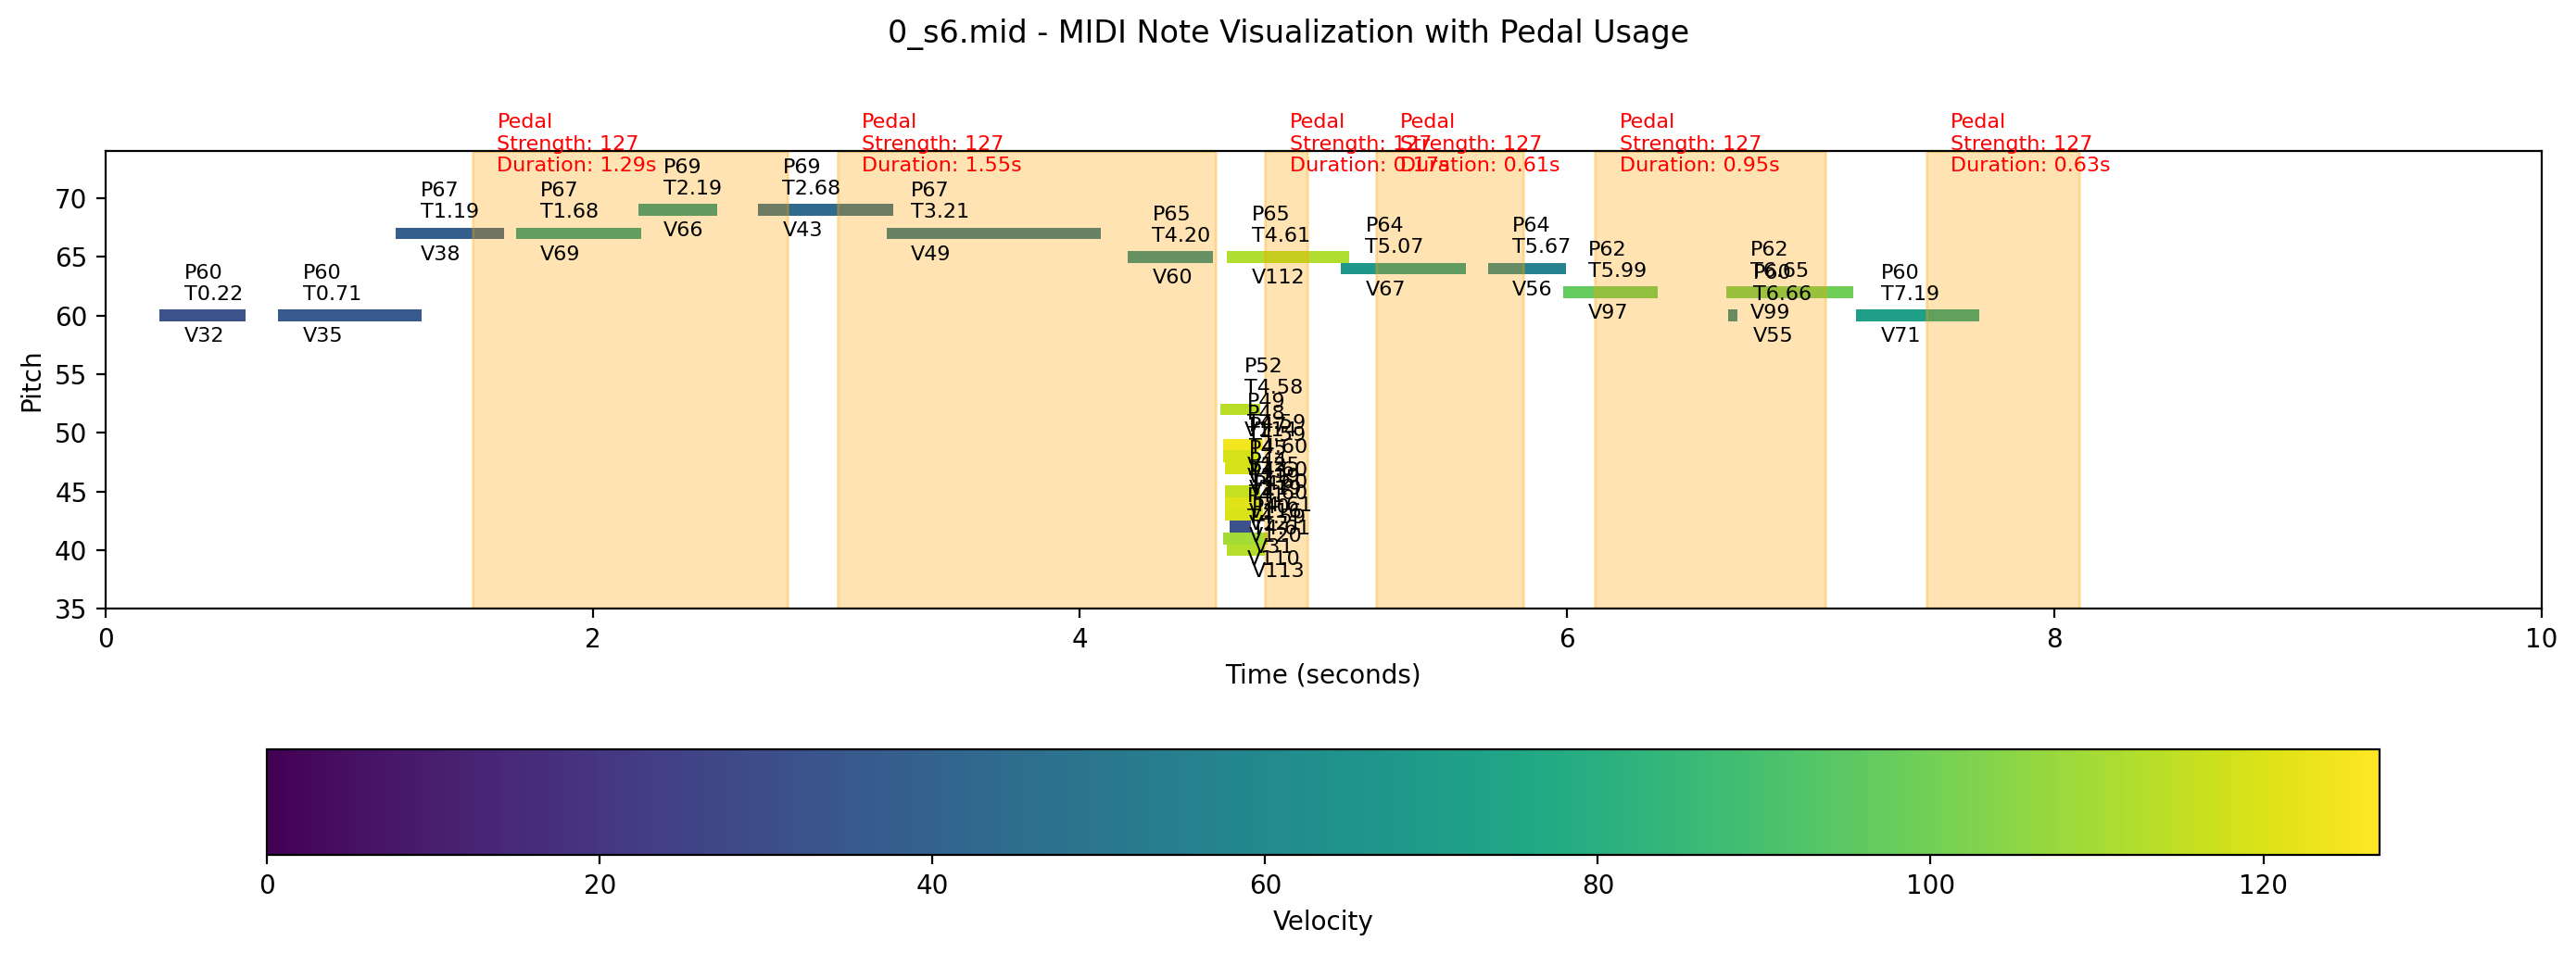

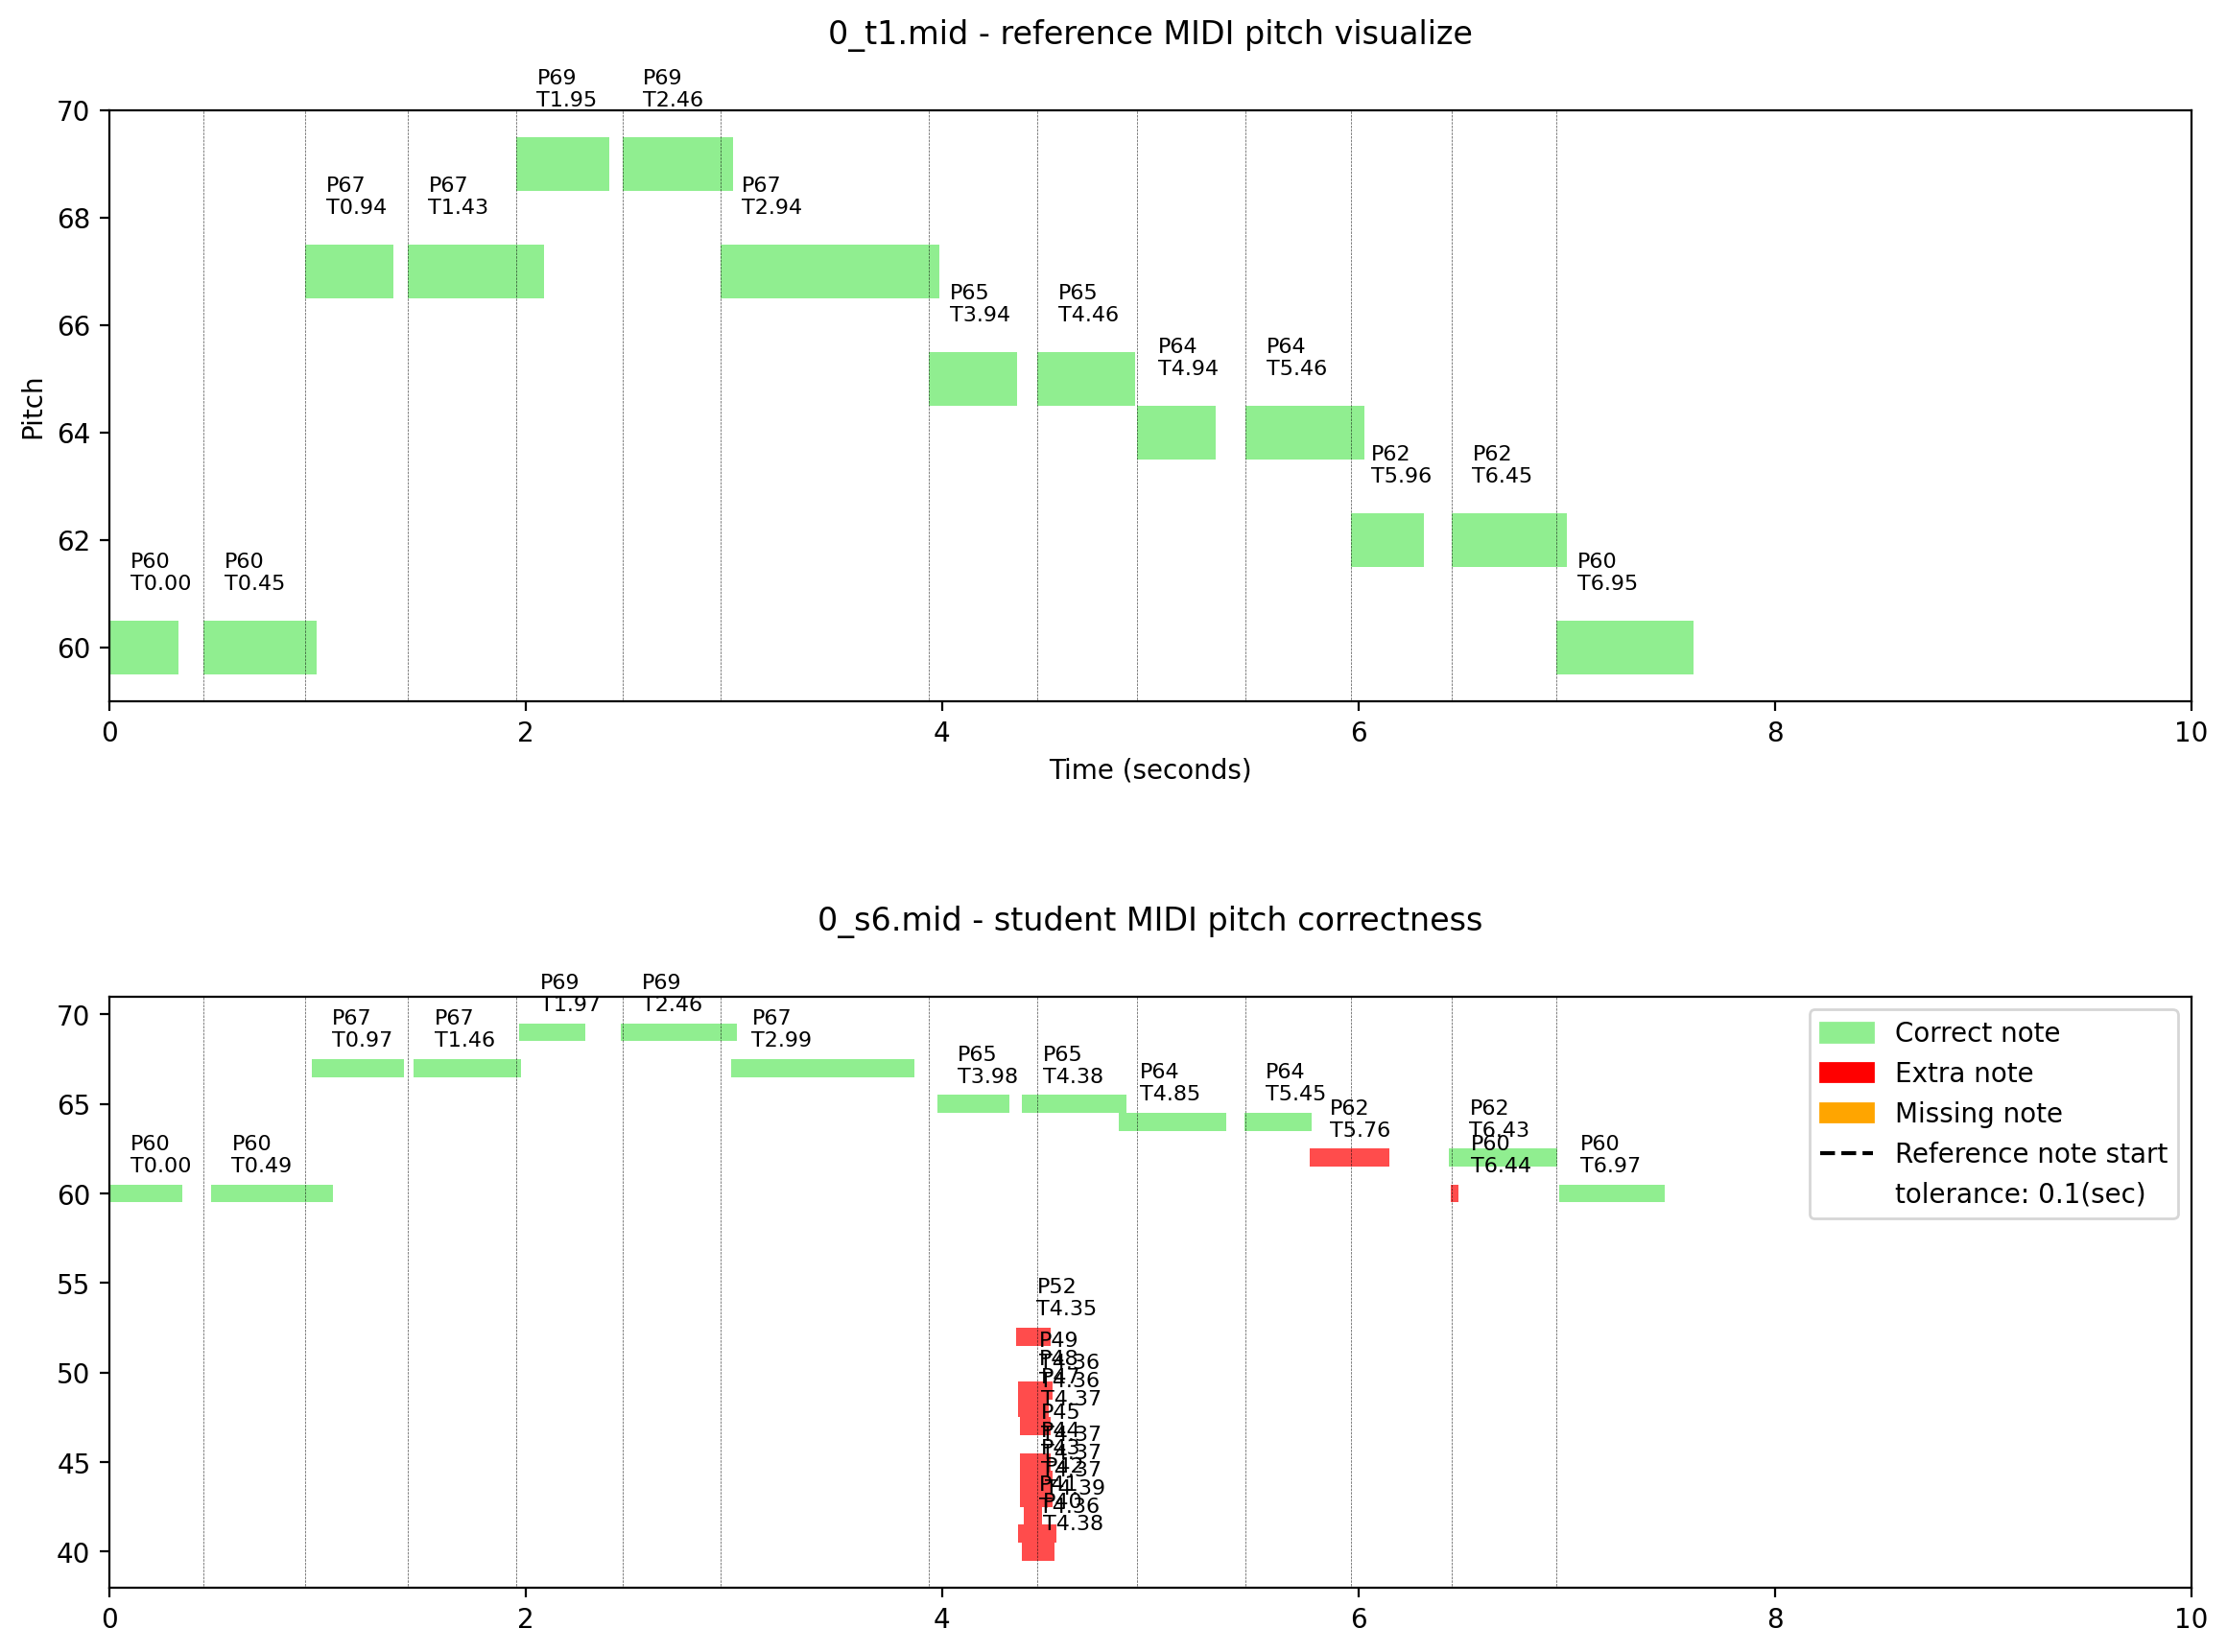

(Pitch, ref_time, stu_time(s))
correct_notes:


[(60, 0.0, 0.0),
 (60, 0.45416666666666666, 0.4875),
 (67, 0.9406249999999999, 0.9708333333333332),
 (67, 1.4322916666666667, 1.4625),
 (69, 1.9531250000000002, 1.9677083333333332),
 (69, 2.4635416666666665, 2.457291666666667),
 (67, 2.936458333333333, 2.9854166666666666),
 (65, 3.9354166666666663, 3.9750000000000005),
 (65, 4.45625, 4.383333333333334),
 (64, 4.9375, 4.8500000000000005),
 (64, 5.45625, 5.453125),
 (62, 6.445833333333334, 6.432291666666667),
 (60, 6.951041666666667, 6.965625)]


extra_notes:


[(42, 4.392708333333333),
 (48, 4.364583333333333),
 (47, 4.373958333333333),
 (52, 4.354166666666667),
 (45, 4.373958333333333),
 (43, 4.373958333333333),
 (44, 4.373958333333333),
 (49, 4.364583333333333),
 (40, 4.383333333333334),
 (41, 4.364583333333333),
 (62, 5.763541666666667),
 (60, 6.440625)]


missing_note:


[(62, 5.961458333333334)]

In [317]:
reference_path = '0_t1.mid'
student_path = '0_s6.mid'


compare_midi_pitch(reference_path, student_path, tolerance=0.1)

In [319]:
#show_sheet('0_t1.mid')

In [320]:
print(mido.get_input_names())  # 列出所有可用的 MIDI 輸入設備

[]


['CASIO USB-MIDI']
開始捕捉 MIDI 訊息，按 'Esc' 結束錄音。
正確: Pitch 60, 範本時間 0.00s, 學生時間 0.00s
Received MIDI message: note_on channel=0 note=60 velocity=42 time=0 (0 ticks)
多餘音符: Pitch 60, 學生時間 0.62s
Received MIDI message: note_on channel=0 note=60 velocity=57 time=0 (125 ticks)
多餘音符: Pitch 67, 學生時間 1.13s
Received MIDI message: note_on channel=0 note=67 velocity=63 time=0 (77 ticks)
多餘音符: Pitch 67, 學生時間 1.65s
Received MIDI message: note_on channel=0 note=67 velocity=60 time=0 (90 ticks)
正確: Pitch 69, 範本時間 2.02s, 學生時間 2.07s
Received MIDI message: note_on channel=0 note=69 velocity=68 time=0 (105 ticks)
正確: Pitch 69, 範本時間 2.48s, 學生時間 2.55s
Received MIDI message: note_on channel=0 note=69 velocity=68 time=0 (96 ticks)
正確: Pitch 67, 範本時間 2.97s, 學生時間 2.98s
Received MIDI message: note_on channel=0 note=67 velocity=64 time=0 (87 ticks)
正確: Pitch 65, 範本時間 3.93s, 學生時間 3.93s
Received MIDI message: note_on channel=0 note=65 velocity=41 time=0 (171 ticks)
正確: Pitch 65, 範本時間 4.45s, 學生時間 4.48s
Received MIDI mes

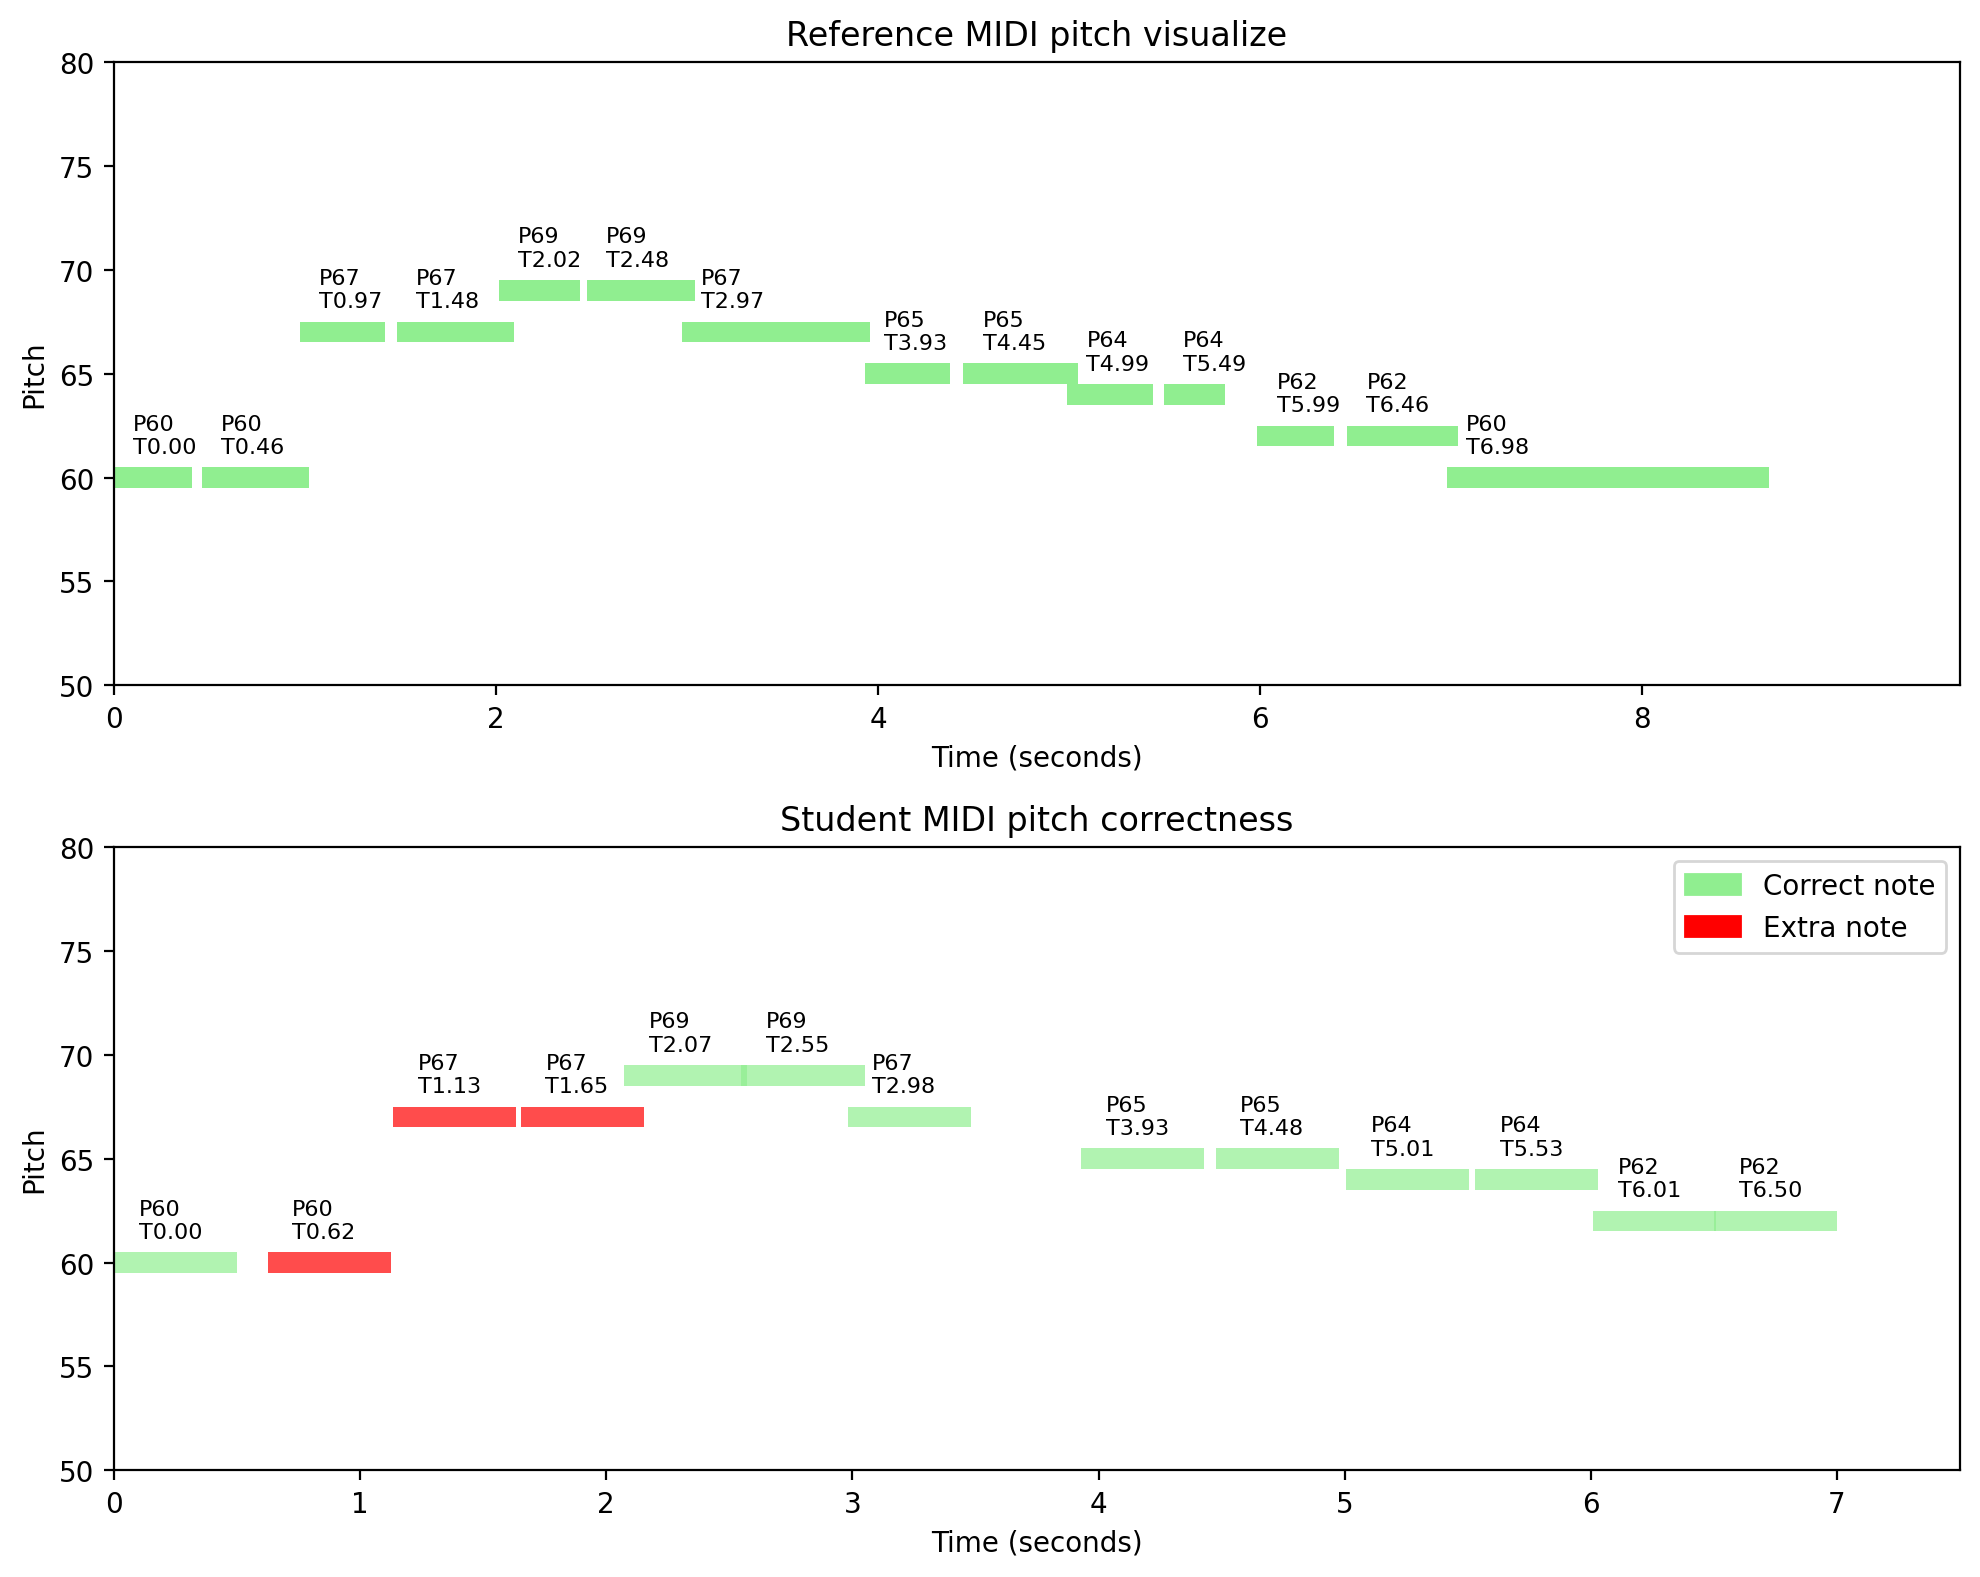

In [366]:
import mido
import time
import keyboard  # 用於偵測按鍵
import pretty_midi
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.animation as animation

print(mido.get_input_names())
port_name = mido.get_input_names()[0] 

# 設定 BPM 和每拍的 ticks 數
BPM = 96  # 設定音樂的速度 (例如每分鐘 96 拍)
ticks_per_beat = 480  # 設定每拍的 ticks 數量

# 計算每秒的 ticks 數
ticks_per_second = (ticks_per_beat * BPM) / 60

# 加載範本 MIDI 並提取範本音符，進行修剪靜音
def load_reference_midi(reference_path):
    ref_midi = pretty_midi.PrettyMIDI(reference_path)
    ref_notes = [(note.pitch, note.start, note.end) for instrument in ref_midi.instruments for note in instrument.notes]
    ref_notes = trim_silence(ref_notes)  # 修剪靜音部分
    return ref_notes

# 修剪靜音部分
def trim_silence(ref_notes):
    if not ref_notes:
        return ref_notes
    # 找到範本 MIDI 中的第一個音符開始時間
    first_note_time = min(note[1] for note in ref_notes)
    # 調整所有音符的時間，使其從 0 開始
    trimmed_notes = [(pitch, start - first_note_time, end - first_note_time) for pitch, start, end in ref_notes]
    return trimmed_notes

# 初始化實時視覺化
def init_visualization(reference_path):
    ref_notes = load_reference_midi(reference_path)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # 繪製範本音符
    for pitch, start, end in ref_notes:
        ax1.barh(pitch, end - start, left=start, height=1, color='lightgreen')
        ax1.text(start + 0.1, pitch + 1, f'P{pitch}\nT{start:.2f}', va='bottom', fontsize=8, ha='left')

    # 設置範本圖的標題、軸標簽等
    ax1.set_title("Reference MIDI pitch visualize")
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Pitch")
    ax1.set_xlim(0, max(note[2] for note in ref_notes) + 1)
    ax1.set_ylim(50, 80)
    
    # 設置學生圖的基本參數
    ax2.set_title("Student MIDI pitch correctness")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Pitch")
    ax2.set_xlim(0, max(note[2] for note in ref_notes) + 1)
    ax2.set_ylim(50, 80)

    # 添加圖例
    correct_patch = mpatches.Patch(color='lightgreen', label='Correct note')
    extra_patch = mpatches.Patch(color='red', label='Extra note')
    ref_note_start_patch = mlines.Line2D([], [], color='black', linestyle='--', label='Reference note start')
    tolerance_label = mlines.Line2D([], [], linestyle='', label=f'tolerance: 0.1(sec)')
    
    ax2.legend(handles=[correct_patch, extra_patch, ref_note_start_patch, tolerance_label], loc='upper right')
    
    plt.tight_layout()
    plt.draw()
    
    return fig, ax1, ax2


def update_visualization(frame, ax2, note_list):
    ax2.clear()  # 清除之前的繪圖
    ax2.set_title("Student MIDI pitch correctness")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Pitch")
    ax2.set_xlim(0, max(note[1] for note in note_list) + 1 if note_list else 10)
    ax2.set_ylim(50, 80)

    for note in note_list:
        pitch, start_time, correct = note
        color = 'lightgreen' if correct else 'red'
        ax2.barh(pitch, 0.5, left=start_time, height=1, color=color, alpha=0.7)
        # 添加 pitch 和時間的標籤
        ax2.text(start_time + 0.1, pitch + 1, f'P{pitch}\nT{start_time:.2f}', va='bottom', fontsize=8, ha='left')

    # 添加圖例
    correct_patch = mpatches.Patch(color='lightgreen', label='Correct note')
    extra_patch = mpatches.Patch(color='red', label='Extra note')
    ax2.legend(handles=[correct_patch, extra_patch], loc='upper right')


# 調整compare_and_visualize來減少誤差
def compare_and_visualize(ref_notes, student_note, ax2, note_list, tolerance=0.1):  # 調整容忍度為0.1秒
    pitch, start_time = student_note
    closest_ref_note = None
    closest_time_diff = float('inf')

    # 比對學生音符與範本，使用更嚴格的誤差容忍度
    for ref_pitch, ref_start, ref_end in ref_notes:
        if ref_pitch == pitch:
            time_diff = abs(start_time - ref_start)
            if time_diff < closest_time_diff and time_diff <= tolerance:
                closest_time_diff = time_diff
                closest_ref_note = (ref_pitch, ref_start)

    # 更新圖表並輸出比對結果
    if closest_ref_note:
        print(f"正確: Pitch {pitch}, 範本時間 {closest_ref_note[1]:.2f}s, 學生時間 {start_time:.2f}s")
        new_note = (pitch, start_time, True)
    else:
        print(f"多餘音符: Pitch {pitch}, 學生時間 {start_time:.2f}s")
        new_note = (pitch, start_time, False)

    # 更新視覺化圖表，新增新音符
    update_visualization(None, ax2, note_list)

    note_list.append(new_note)  # 繪製音符的清單





# 指定 MIDI 輸入設備
def start_real_time_midi_capture(reference_path):
    # 加載範本 MIDI 音符
    ref_notes = load_reference_midi(reference_path)
    
    # 創建一個新的 MIDI 文件和軌道
    midi_file = mido.MidiFile()
    midi_track = mido.MidiTrack()
    midi_file.tracks.append(midi_track)

    print("開始捕捉 MIDI 訊息，按 'Esc' 結束錄音。")
    start_time = time.time()
    last_time = start_time  # 記錄上一條 MIDI 訊息的時間
    student_notes = []  # 存儲學生的音符
    note_list = []  # 存儲繪製音符的清單

    duration = 12
    start_flag = False

    # 初始化實時視覺化
    fig, ax1, ax2 = init_visualization(reference_path)

    # 指定 MIDI 輸入設備
    with mido.open_input(port_name) as midi_in:

        def handle_midi(message):
            nonlocal last_time
            current_time = time.time()
            elapsed_time = current_time - last_time  # 計算與上一條訊息的時間差
            ticks = int(elapsed_time * ticks_per_second)  # 將時間轉換為 ticks

            # 判斷是否為音符類型的訊息
            if message.type in ['note_on', 'note_off']:
                # 只處理音符按下的訊息
                if message.type == 'note_on' and message.velocity > 0:
                    note_start_time = current_time - start_time
                    student_note = (message.note, note_start_time)
                    student_notes.append(student_note)  # 學生音符
                    compare_and_visualize(ref_notes, student_note, ax2, note_list)  # 實時比對與視覺化
                    print(f"Received MIDI message: {message} ({ticks} ticks)")

            last_time = current_time  # 更新 last_time

        try:
            while time.time() - start_time < duration:
                for message in midi_in.iter_pending():
                    start_flag = True
                    handle_midi(message)
                time.sleep(0.00001)  # 輕微延遲降低 CPU 使用
                if keyboard.is_pressed('esc'):  # 偵測 'Esc' 按鍵退出
                    print("偵測到 Esc，結束錄音。")
                    break
                if (not start_flag): #checking if the first key is pressed or not postpone the ending  
                    start_time = time.time()
                    last_time = start_time

                    
        except KeyboardInterrupt:
            print("結束錄音。")

    # 保存 MIDI 文件
    #output_filename = input("Please input your file name: ") + ".mid"
    #midi_file.save(output_filename)
    #print(f"MIDI 訊息已保存到 {output_filename}")

# 使用方法：
reference_midi_path = '0_t2.mid'  # 指定範本 MIDI 的路徑
start_real_time_midi_capture(reference_midi_path)

# plt.show() 僅在最後一次調用
plt.show()






In [63]:
import mido
import time
import keyboard  # 用於偵測按鍵
import pretty_midi
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib

print(mido.get_input_names())
port_name = mido.get_input_names()[0] 

# 設定 BPM 和每拍的 ticks 數
BPM = 96  # 設定音樂的速度 (例如每分鐘 96 拍)
ticks_per_beat = 480  # 設定每拍的 ticks 數量

# 計算每秒的 ticks 數
ticks_per_second = (ticks_per_beat * BPM) / 60

# 加載範本 MIDI 並提取範本音符，進行修剪靜音
def load_reference_midi(reference_path):
    ref_midi = pretty_midi.PrettyMIDI(reference_path)
    ref_notes = [(note.pitch, note.start, note.end) for instrument in ref_midi.instruments for note in instrument.notes]
    ref_notes = trim_silence(ref_notes)  # 修剪靜音部分
    return ref_notes

# 修剪靜音部分
def trim_silence(ref_notes):
    if not ref_notes:
        return ref_notes
    # 找到範本 MIDI 中的第一個音符開始時間
    first_note_time = min(note[1] for note in ref_notes)
    # 調整所有音符的時間，使其從 0 開始
    trimmed_notes = [(pitch, start - first_note_time, end - first_note_time) for pitch, start, end in ref_notes]
    return trimmed_notes

# 初始化實時視覺化
# 初始化實時視覺化
def init_visualization(reference_path):
    ref_notes = load_reference_midi(reference_path)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # 繪製範本音符
    for pitch, start, end in ref_notes:
        ax1.barh(pitch, end - start, left=start, height=1, color='lightgreen')
        ax1.text(start + 0.1, pitch + 1, f'P{pitch}\nT{start:.2f}', va='bottom', fontsize=8, ha='left')

    # 設置範本圖的標題、軸標簽等
    ax1.set_title("Reference MIDI pitch visualize")
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Pitch")
    ax1.set_xlim(0, 10)  # 固定 x 軸範圍為 0 到 10 秒
    ax1.set_ylim(50, 80)
    
    # 設置學生圖的基本參數
    ax2.set_title("Student MIDI pitch correctness")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Pitch")
    ax2.set_xlim(0, 10)  # 固定 x 軸範圍為 0 到 10 秒
    ax2.set_ylim(50, 80)

    # 添加圖例
    correct_patch = mpatches.Patch(color='lightgreen', label='Correct note')
    extra_patch = mpatches.Patch(color='red', label='Extra note')
    ref_note_start_patch = mlines.Line2D([], [], color='black', linestyle='--', label='Reference note start')
    tolerance_label = mlines.Line2D([], [], linestyle='', label=f'tolerance: 0.1(sec)')
    
    ax2.legend(handles=[correct_patch, extra_patch, ref_note_start_patch, tolerance_label], loc='upper right')
    
    plt.tight_layout()
    plt.draw()
    
    return fig, ax1, ax2


def update_visualization(ax2, note_list):
    ax2.clear()  # 清除之前的繪圖
    ax2.set_title("Student MIDI pitch correctness")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Pitch")
    ax2.set_xlim(0, 10)  # 固定 x 軸範圍為 0 到 10 秒
    ax2.set_ylim(50, 80)

    for note in note_list:
        pitch, start_time, end_time, correct = note
        duration = end_time - start_time  # 計算音符的長度
        color = 'lightgreen' if correct else 'red'
        ax2.barh(pitch, duration, left=start_time, height=1, color=color, alpha=0.7)
        # 添加 pitch 和時間的標籤
        ax2.text(start_time + 0.1, pitch + 1, f'P{pitch}\nT{start_time:.2f}', va='bottom', fontsize=8, ha='left')

    # 添加圖例
    correct_patch = mpatches.Patch(color='lightgreen', label='Correct note')
    extra_patch = mpatches.Patch(color='red', label='Extra note')
    ax2.legend(handles=[correct_patch, extra_patch], loc='upper right')
    
    ax2.figure.canvas.flush_events()  # 刷新圖表以實時顯示更新


# 調整compare_and_visualize來減少誤差
def compare_and_visualize(ref_notes, student_note, ax2, note_list, tolerance=0.1):  # 調整容忍度為0.1秒
    pitch, start_time, end_time = student_note  # 學生音符現在包含結束時間
    closest_ref_note = None
    closest_time_diff = float('inf')

    # 比對學生音符與範本，使用更嚴格的誤差容忍度
    for ref_pitch, ref_start, ref_end in ref_notes:
        if ref_pitch == pitch:
            time_diff = abs(start_time - ref_start)
            if time_diff < closest_time_diff and time_diff <= tolerance:
                closest_time_diff = time_diff
                closest_ref_note = (ref_pitch, ref_start)

    # 更新圖表並輸出比對結果
    if closest_ref_note:
        #print(f"正確: Pitch {pitch}, 範本時間 {closest_ref_note[1]:.2f}s, 學生時間 {start_time:.2f}s")
        new_note = (pitch, start_time, end_time, True)  # 使用開始和結束時間
    else:
        #print(f"多餘音符: Pitch {pitch}, 學生時間 {start_time:.2f}s")
        new_note = (pitch, start_time, end_time, False)

    note_list.append(new_note)  # 繪製音符的清單
    update_visualization(ax2, note_list)  # 實時更新圖表

# 指定 MIDI 輸入設備
def start_real_time_midi_capture(reference_path):
    # 加載範本 MIDI 音符
    ref_notes = load_reference_midi(reference_path)
    
    # 創建一個新的 MIDI 文件和軌道
    midi_file = mido.MidiFile()
    midi_track = mido.MidiTrack()
    midi_file.tracks.append(midi_track)

    print("開始捕捉 MIDI 訊息，按 'Esc' 結束錄音。")
    start_time = time.perf_counter()  # 使用更高精度的時間函數
    last_time = start_time  # 記錄上一條 MIDI 訊息的時間
    student_notes = {}  # 用於存儲學生的音符，並記錄開始時間和結束時間
    note_list = []  # 存儲繪製音符的清單

    duration = 10
    start_flag = False

    # 初始化實時視覺化
    fig, ax1, ax2 = init_visualization(reference_path)

    # 指定 MIDI 輸入設備
    with mido.open_input(port_name) as midi_in:

        def handle_midi(message):
            nonlocal last_time
            current_time = time.perf_counter()  # 使用更高精度的時間函數
            elapsed_time = current_time - last_time  # 計算與上一條訊息的時間差
            ticks = int(elapsed_time * ticks_per_second)  # 將時間轉換為 ticks

            # 處理 note_on 和 note_off 訊息
            if message.type == 'note_on' and message.velocity > 0:
                note_start_time = current_time - start_time
                student_notes[message.note] = note_start_time  # 記錄音符的開始時間
                #print(f"note_on: Pitch {message.note} at {note_start_time:.2f}s")

            elif message.type == 'note_off' or (message.type == 'note_on' and message.velocity == 0):
                note_end_time = current_time - start_time
                if message.note in student_notes:
                    note_start_time = student_notes.pop(message.note)
                    student_note = (message.note, note_start_time, note_end_time)
                    compare_and_visualize(ref_notes, student_note, ax2, note_list)  # 實時比對與視覺化
                    #print(f"note_off: Pitch {message.note} ends at {note_end_time:.2f}s")

            last_time = current_time  # 更新 last_time

        try:
            while time.perf_counter() - start_time < duration:
                for message in midi_in.iter_pending():
                    start_flag = True
                    handle_midi(message)
                time.sleep(0.01)  # 輕微延遲降低 CPU 使用
                if keyboard.is_pressed('esc'):  # 偵測 'Esc' 按鍵退出
                    print("偵測到 Esc，結束錄音。")
                    break
                if not start_flag:  # 如果尚未開始按鍵，延遲計時器
                    start_time = time.perf_counter()
                    last_time = start_time

        except KeyboardInterrupt:
            print("結束錄音。")


# 使用方法：
reference_midi_path = '0_t2.mid'  # 指定範本 MIDI 的路徑
start_real_time_midi_capture(reference_midi_path)

plt.show()


[]


IndexError: list index out of range

['CASIO USB-MIDI']
開始捕捉 MIDI 訊息，按 'Esc' 結束錄音。


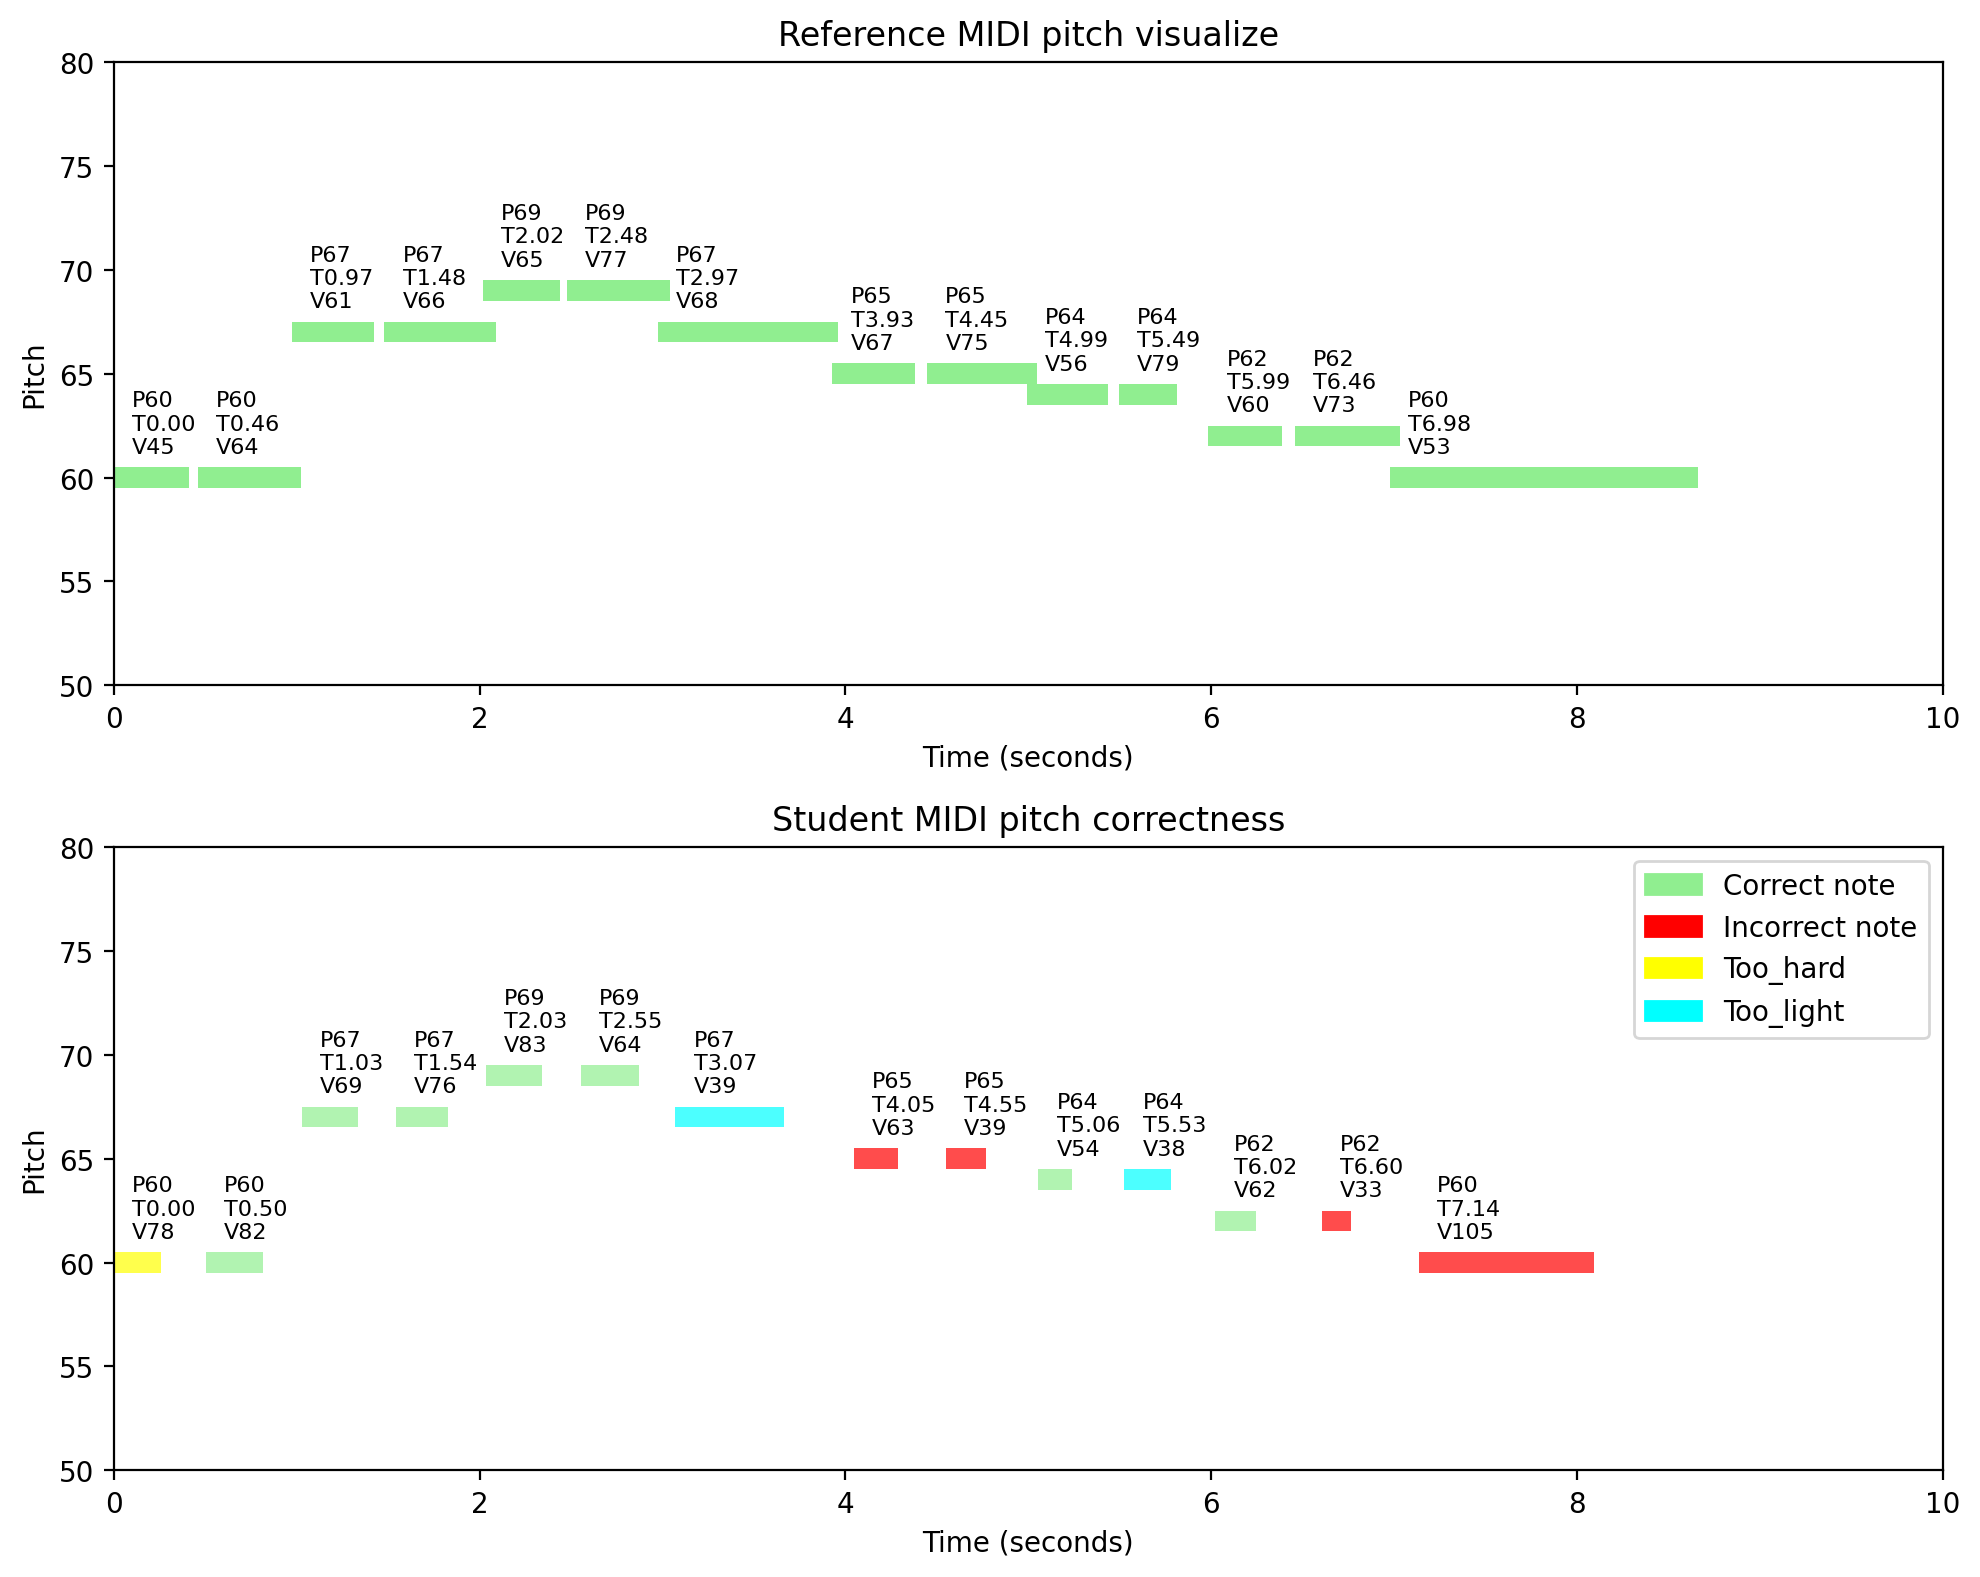

In [78]:
import mido
import time
import keyboard
import pretty_midi
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

print(mido.get_input_names())
port_name = mido.get_input_names()[0]

# 設定 BPM 和每拍的 ticks 數
BPM = 96
ticks_per_beat = 480

# 計算每秒的 ticks 數
ticks_per_second = (ticks_per_beat * BPM) / 60

# 加載範本 MIDI 並提取範本音符，進行修剪靜音
def load_reference_midi(reference_path):
    ref_midi = pretty_midi.PrettyMIDI(reference_path)
    ref_notes = [(note.pitch, note.start, note.end, note.velocity) for instrument in ref_midi.instruments for note in instrument.notes]
    ref_notes = trim_silence(ref_notes)
    return ref_notes

# 修剪靜音部分
def trim_silence(ref_notes):
    if not ref_notes:
        return ref_notes
    first_note_time = min(note[1] for note in ref_notes)
    trimmed_notes = [(pitch, start - first_note_time, end - first_note_time, velocity) for pitch, start, end, velocity in ref_notes]
    return trimmed_notes

# 初始化實時視覺化
def init_visualization(reference_path):
    ref_notes = load_reference_midi(reference_path)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # 繪製範本音符
    for pitch, start, end, velocity in ref_notes:
        ax1.barh(pitch, end - start, left=start, height=1, color='lightgreen')
        ax1.text(start + 0.1, pitch + 1, f'P{pitch}\nT{start:.2f}\nV{velocity}', va='bottom', fontsize=8, ha='left')

    ax1.set_title("Reference MIDI pitch visualize")
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Pitch")
    ax1.set_xlim(0, 10)
    ax1.set_ylim(50, 80)

    ax2.set_title("Student MIDI pitch correctness")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Pitch")
    ax2.set_xlim(0, 10)
    ax2.set_ylim(50, 80)

    # 添加圖例
    correct_patch = mpatches.Patch(color='lightgreen', label='Correct note')
    extra_patch = mpatches.Patch(color='red', label='Incorrect note')
    velocity_off_patch = mpatches.Patch(color='yellow', label='Velocity off')
    ref_note_start_patch = mlines.Line2D([], [], color='black', linestyle='--', label='Reference note start')
    tolerance_label = mlines.Line2D([], [], linestyle='', label=f'tolerance: 0.1(sec)')

    ax2.legend(handles=[correct_patch, extra_patch, velocity_off_patch, ref_note_start_patch, tolerance_label], loc='upper right')
    
    plt.tight_layout()
    plt.draw()
    
    return fig, ax1, ax2

def update_visualization(ax2, note_list):
    ax2.clear()
    ax2.set_title("Student MIDI pitch correctness")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Pitch")
    ax2.set_xlim(0, 10)
    ax2.set_ylim(50, 80)

    for note in note_list:
        pitch, start_time, end_time, correct, color, velocity = note
        duration = end_time - start_time
        ax2.barh(pitch, duration, left=start_time, height=1, color=color, alpha=0.7)
        ax2.text(start_time + 0.1, pitch + 1, f'P{pitch}\nT{start_time:.2f}\nV{velocity}', va='bottom', fontsize=8, ha='left')

    # 添加圖例
    correct_patch = mpatches.Patch(color='lightgreen', label='Correct note')
    extra_patch = mpatches.Patch(color='red', label='Incorrect note')
    Too_hard= mpatches.Patch(color='yellow', label='Too_hard')
    Too_light = mpatches.Patch(color='cyan', label='Too_light')
    
    ax2.legend(handles=[correct_patch, extra_patch, Too_hard, Too_light], loc='upper right')
    
    ax2.figure.canvas.flush_events()

# 調整compare_and_visualize來處理velocity
def compare_and_visualize(ref_notes, student_note, ax2, note_list, tolerance=0.1, velocity_tolerance=20):
    pitch, start_time, end_time, velocity = student_note
    closest_ref_note = None
    closest_time_diff = float('inf')

    # 比對音高、時間和力度
    for ref_pitch, ref_start, ref_end, ref_velocity in ref_notes:
        if ref_pitch == pitch:
            time_diff = abs(start_time - ref_start)
            if time_diff < closest_time_diff and time_diff <= tolerance:
                closest_time_diff = time_diff
                closest_ref_note = (ref_pitch, ref_start, ref_end, ref_velocity)

    if closest_ref_note:
        ref_pitch, ref_start, ref_end, ref_velocity = closest_ref_note

        if abs(ref_velocity - velocity) <= velocity_tolerance:
            color = 'lightgreen'  # 力度差異在容差範圍內
        elif ref_velocity - velocity < -velocity_tolerance:
            color = 'yellow'  # 力度差異超出容差範圍
        else:
            color = "cyan"
        new_note = (pitch, start_time, end_time, True, color, velocity)
    else:
        new_note = (pitch, start_time, end_time, False, 'red', velocity)  # 音高錯誤顯示紅色

    note_list.append(new_note)
    update_visualization(ax2, note_list)

# 捕捉MIDI輸入，並處理velocity
def start_real_time_midi_capture(reference_path):
    ref_notes = load_reference_midi(reference_path)
    
    midi_file = mido.MidiFile()
    midi_track = mido.MidiTrack()
    midi_file.tracks.append(midi_track)

    print("開始捕捉 MIDI 訊息，按 'Esc' 結束錄音。")
    start_time = time.perf_counter()
    last_time = start_time
    student_notes = {}
    note_list = []

    duration = 10
    start_flag = False

    fig, ax1, ax2 = init_visualization(reference_path)

    with mido.open_input(port_name) as midi_in:

        def handle_midi(message):
            nonlocal last_time
            current_time = time.perf_counter()
            elapsed_time = current_time - last_time
            ticks = int(elapsed_time * ticks_per_second)

            if message.type == 'note_on' and message.velocity > 0:
                note_start_time = current_time - start_time
                student_notes[message.note] = (note_start_time, message.velocity)

            elif message.type == 'note_off' or (message.type == 'note_on' and message.velocity == 0):
                note_end_time = current_time - start_time
                if message.note in student_notes:
                    note_start_time, velocity = student_notes.pop(message.note)
                    student_note = (message.note, note_start_time, note_end_time, velocity)
                    compare_and_visualize(ref_notes, student_note, ax2, note_list)

            last_time = current_time

        try:
            while time.perf_counter() - start_time < duration:
                for message in midi_in.iter_pending():
                    start_flag = True
                    handle_midi(message)
                time.sleep(0.01)
                if keyboard.is_pressed('esc'):
                    print("偵測到 Esc，結束錄音。")
                    break
                if not start_flag:
                    start_time = time.perf_counter()
                    last_time = start_time

        except KeyboardInterrupt:
            print("結束錄音。")


# 使用方法
reference_midi_path = '0_t2.mid'
start_real_time_midi_capture(reference_midi_path)

plt.show()


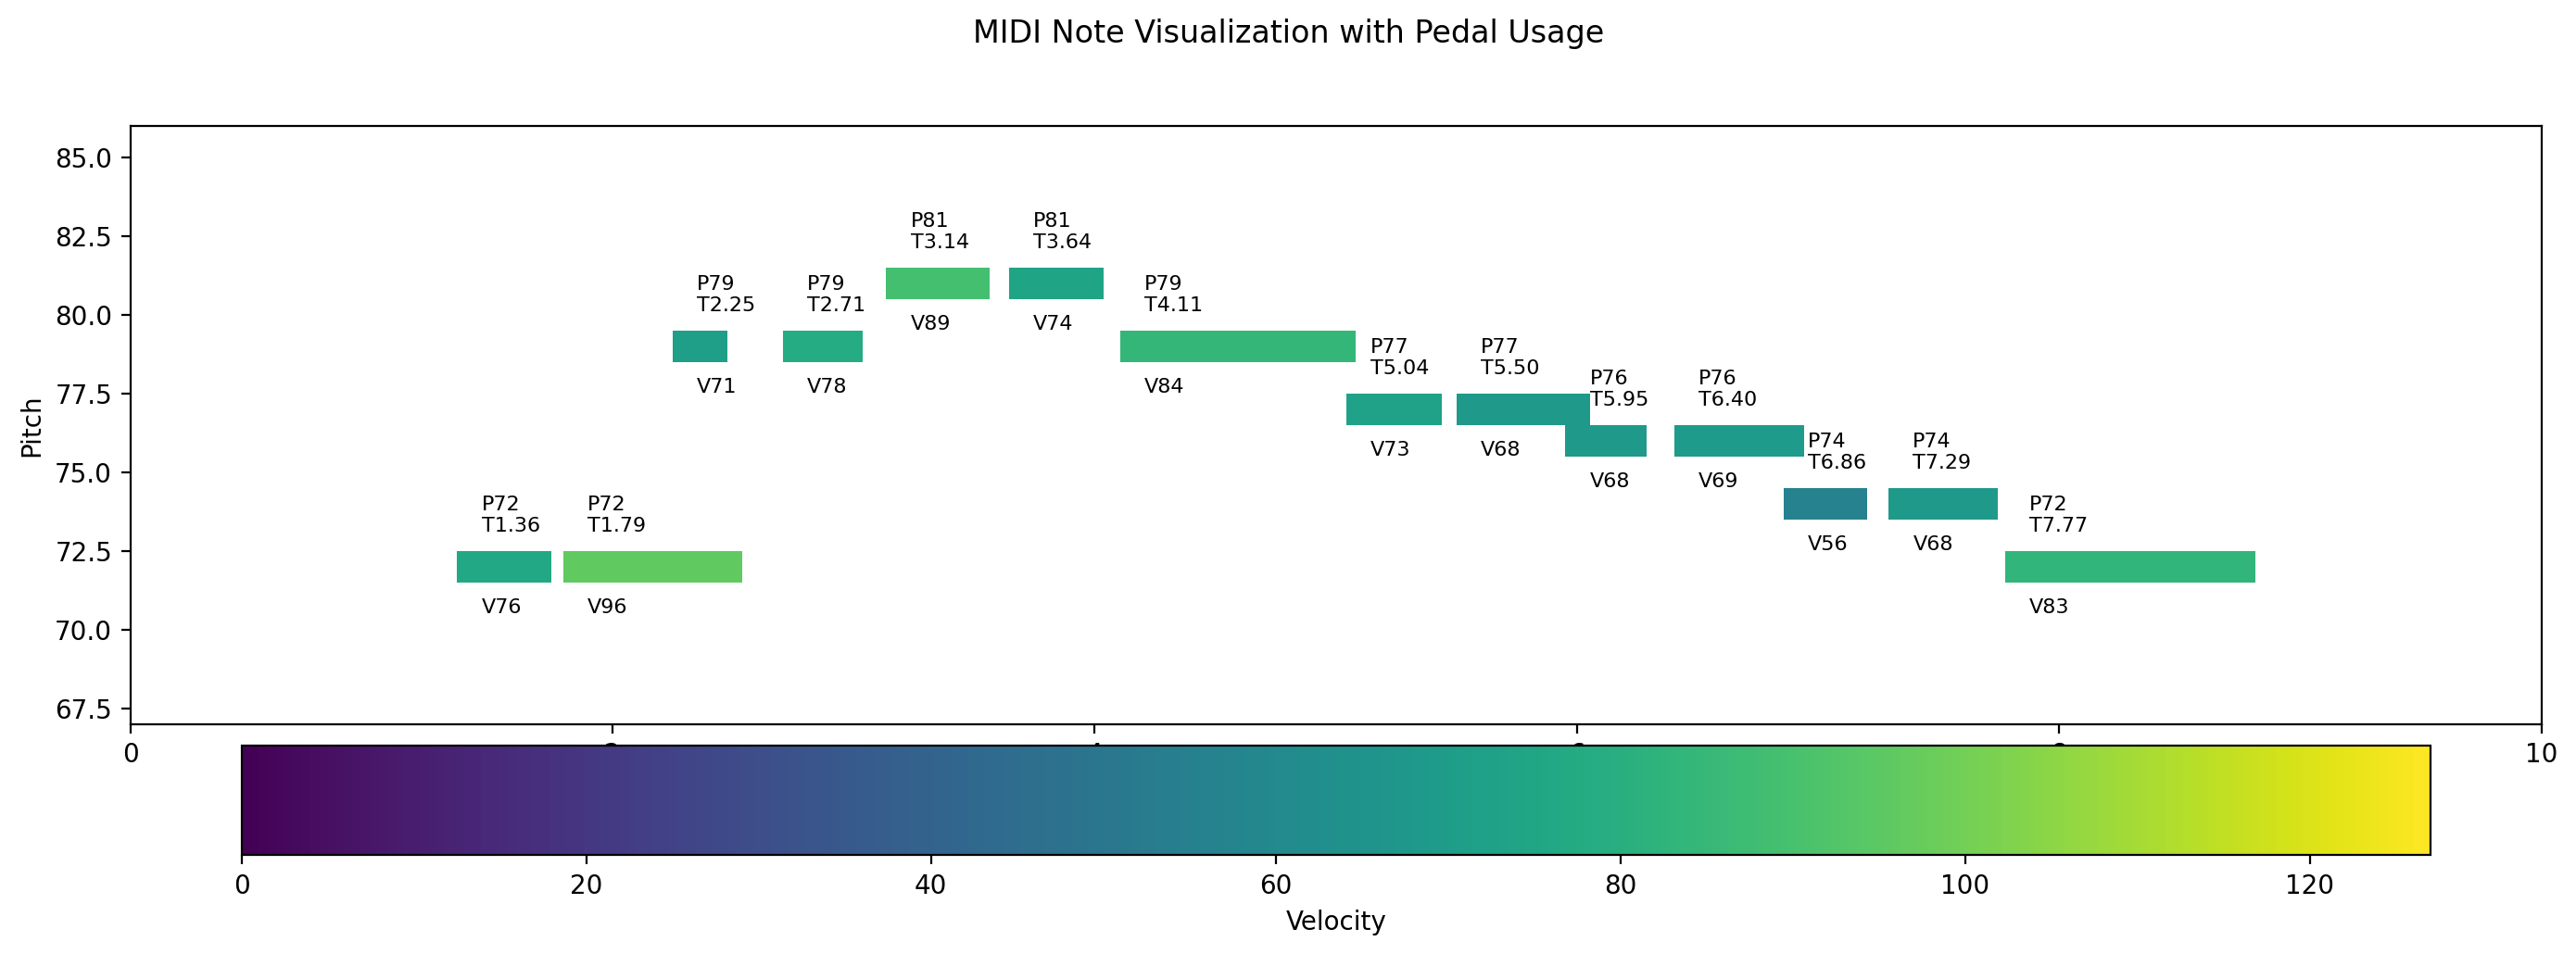

In [48]:
midi_visualize("000.mid")